## Predict.ipynb
#### **This notebook:**
- Loads a wav2vec2 model and performs ASR
- Loads a transcription, and performs sentiment analysis
    - Transcriptions can be either ground truths or obtained from another S2T model

#### **Models**
- **Transcrptions From:** Whisper-Large-v3
- **Sentiment Analysis Model:** Twitter-roBERTa-base for Sentiment Analysis

## Setup

In [235]:
# Run
SEED = 22
FOLD = 9

# Models
PRIMARY_MODEL_NAME = "facebook/wav2vec2-base"
TRANSCRIPTION_MODEL_NAME = "openai/whisper-large-v3"
SENTIMENT_MODEL_NAME = "cardiffnlp/twitter-xlm-roberta-base-sentiment"

# Flag to enable parsing of arguments when converted to script. Set true after converting
PYTHON_SCRIPT = False

### For Conversion to .py file

In [236]:
if PYTHON_SCRIPT:

    import argparse

    parser = argparse.ArgumentParser(description="")
    parser.add_argument('--seed',default=2021,type=int)
    parser.add_argument('--fold',type=int,required=True)
    parser.add_argument('--remap',type=bool,required=True)
    parser.add_argument('--threshold',type=float,required=False)
    parser.add_argument('--mode',required=False)
    parser.add_argument('--flip',type=bool,required=False)

    # Parse the arguments
    args = parser.parse_args()

    # Run
    SEED = args.seed
    FOLD = args.fold
    RUN_REMAP = args.remap
    THRESHOLD = args.threshold
    MODE = args.mode
    FLIP = args.flip

## Folders

In [237]:
# Filepaths
OUTPUT_FOLDER = f'./fold_{FOLD}'
LOG_OUTPUT = OUTPUT_FOLDER + f'/fold-{FOLD}-predict.log'

# Previously trained model paths
PREVIOUSLY_TRAINED_FOLDER = "../../../wav2vec2/"
PREVIOUSLY_TRAINED_MODEL = PREVIOUSLY_TRAINED_FOLDER + f"fold_{FOLD}/wav2vec2-test"

### Dataset Setup

In [238]:
# Dataset
TSV = r'C:\Users\ChenYi\Downloads\AAI3001_Project\labels\IEMOCAP_4.tsv'
AUDIO_DIRECTORY = r'C:\Users\ChenYi\Downloads\AAI3001_Project\small-project\IEMOCAP_full_release_audio'

# Contains the correct transcription to work on. Can be either ground truths or predictions by other models
TRANSCRIPTIONS_FILE = './transcriptions/full_transcriptions.csv'

#### Select GPUs (For multi-GPU setup)

In [239]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

### Logger

In [240]:
import logging
def get_logger(filename, verbosity=1, name=None):
    level_dict = {0: logging.DEBUG, 1: logging.INFO, 2: logging.WARNING}
    formatter = logging.Formatter("[%(asctime)s][%(filename)s][line:%(lineno)d][%(levelname)s] %(message)s")
    logger = logging.getLogger(name)
    logger.setLevel(level_dict[verbosity])

    fh = logging.FileHandler(filename, "w")
    fh.setFormatter(formatter)                                                                                                                                                                                     
    logger.addHandler(fh)                                                                                                                                                                                          
                                                                                                                                                                                                                   
    sh = logging.StreamHandler()                                                                                                                                                                                   
    sh.setFormatter(formatter)                                                                                                                                                                                     
    logger.addHandler(sh)                                                                                                                                                                                          
                                                                                                                                                                                                                   
    return logger
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
logger = get_logger(LOG_OUTPUT)

### NLP Preprocessing Settings

In [241]:
APPLY_NLP_PREPROCESS = True
APPLY_CONTRACTIONS = True
APPLY_LEMMANTIZATION = True
APPLY_REMOVE_STOPWORDS = False
APPLY_REMOVE_NUMBERS = True  

## Imports

In [242]:
import csv
import torch
import random
import librosa
import torchaudio
import contractions
import torch.nn as nn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
from torchaudio import functional as audioF
from torchaudio.transforms import Resample
from torchaudio.compliance import kaldi
from torch.utils.data import Dataset, DataLoader
#from transformers import EarlyStoppingCallback, AdamW, get_scheduler
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, pipeline
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification
from sklearn.metrics import confusion_matrix, classification_report, recall_score, accuracy_score

# NLP Stuff
import re
import spacy
import string
from nltk.corpus import stopwords
nlp = spacy.load("en_core_web_sm")
mapping = str.maketrans('', '', string.digits) # table to remove strings

### Log Details

In [243]:
logger.info("----- Models -----")
logger.info(f"Primary Model: {PRIMARY_MODEL_NAME}")
logger.info(f"Transcription Model: {TRANSCRIPTION_MODEL_NAME}")
logger.info(f"Sentiment Model: {SENTIMENT_MODEL_NAME}")
logger.info("----- Parameters -----")
logger.info(f"Seed: {SEED}")
logger.info(f"Fold: {FOLD}")

logger.info("----- NLP Options -----")
if APPLY_NLP_PREPROCESS:
    logger.info(f"Apply Preprocessing: YES")
    logger.info(f"Remove Contractions: {APPLY_CONTRACTIONS}")
    logger.info(f"Apply Lemmantization: {APPLY_LEMMANTIZATION}")
    logger.info(f"Remove Numbers: {APPLY_REMOVE_NUMBERS}")
    logger.info(f"Remove Stopwords: {APPLY_REMOVE_STOPWORDS}") 
else:
    logger.info(f"Apply Preprocessing: NO")
logger.info("--------------------")

[2025-03-07 07:17:05,423][3029545133.py][line:1][INFO] ----- Models -----
[2025-03-07 07:17:05,423][3029545133.py][line:1][INFO] ----- Models -----
[2025-03-07 07:17:05,423][3029545133.py][line:1][INFO] ----- Models -----
[2025-03-07 07:17:05,423][3029545133.py][line:1][INFO] ----- Models -----
[2025-03-07 07:17:05,423][3029545133.py][line:1][INFO] ----- Models -----
[2025-03-07 07:17:05,423][3029545133.py][line:1][INFO] ----- Models -----
[2025-03-07 07:17:05,423][3029545133.py][line:1][INFO] ----- Models -----
[2025-03-07 07:17:05,423][3029545133.py][line:1][INFO] ----- Models -----
[2025-03-07 07:17:05,423][3029545133.py][line:1][INFO] ----- Models -----
[2025-03-07 07:17:05,423][3029545133.py][line:1][INFO] ----- Models -----
[2025-03-07 07:17:05,434][3029545133.py][line:2][INFO] Primary Model: facebook/wav2vec2-base
[2025-03-07 07:17:05,434][3029545133.py][line:2][INFO] Primary Model: facebook/wav2vec2-base
[2025-03-07 07:17:05,434][3029545133.py][line:2][INFO] Primary Model: face

### Provided Code

In [244]:
class Pad_trunc_wav(nn.Module):
    def __init__(self, max_len: int = 6*16000):
        super(Pad_trunc_wav, self).__init__()
        self.max_len = max_len
    def forward(self,x):
        shape = x.shape
        length = shape[1]
        if length < self.max_len:
            multiple = self.max_len//length+1
            x_tmp = torch.cat((x,)*multiple, axis=1)
            x_new = x_tmp[:,0:self.max_len]
        else:
            x_new = x[:,0:self.max_len]
        return x_new

In [245]:
def setup_seed(seed=2021):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
setup_seed(SEED)

### Download Required Models

In [246]:
# Load sentiment analysis model
sentiment_task = pipeline("sentiment-analysis",
                          model=SENTIMENT_MODEL_NAME,
                          tokenizer=SENTIMENT_MODEL_NAME,
                          device=0)

logger.info(F"Sentiment model loaded from {SENTIMENT_MODEL_NAME} successfully")

C:\Users\ChenYi\anaconda3\envs\aai3001\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
[2025-03-07 07:17:09,193][3134409386.py][line:7][INFO] Sentiment model loaded from cardiffnlp/twitter-xlm-roberta-base-sentiment successfully
[2025-03-07 07:17:09,193][3134409386.py][line:7][INFO] Sentiment model loaded from cardiffnlp/twitter-xlm-roberta-base-sentiment successfully
[2025-03-07 07:17:09,193][3134409386.py][line:7][INFO] Sentiment model loaded from cardiffnlp/twitter-xlm-roberta-base-sentiment successfully
[2025-03-07 07:17:09,193][3134409386.py][line:7][INFO] Sentiment model loaded from cardiffnlp/twitter-xlm-roberta-base-sentiment successfully
[2025-03-07 07:17:09,193

### Load Previously Trained Model

In [247]:
model = Wav2Vec2ForSequenceClassification.from_pretrained(PREVIOUSLY_TRAINED_MODEL)
model.to('cuda')
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(PREVIOUSLY_TRAINED_MODEL)
logger.info(f"Previously trained model loaded from: {PREVIOUSLY_TRAINED_MODEL}")

[2025-03-07 07:17:09,526][3833462198.py][line:4][INFO] Previously trained model loaded from: ../../../wav2vec2/fold_9/wav2vec2-test
[2025-03-07 07:17:09,526][3833462198.py][line:4][INFO] Previously trained model loaded from: ../../../wav2vec2/fold_9/wav2vec2-test
[2025-03-07 07:17:09,526][3833462198.py][line:4][INFO] Previously trained model loaded from: ../../../wav2vec2/fold_9/wav2vec2-test
[2025-03-07 07:17:09,526][3833462198.py][line:4][INFO] Previously trained model loaded from: ../../../wav2vec2/fold_9/wav2vec2-test
[2025-03-07 07:17:09,526][3833462198.py][line:4][INFO] Previously trained model loaded from: ../../../wav2vec2/fold_9/wav2vec2-test
[2025-03-07 07:17:09,526][3833462198.py][line:4][INFO] Previously trained model loaded from: ../../../wav2vec2/fold_9/wav2vec2-test
[2025-03-07 07:17:09,526][3833462198.py][line:4][INFO] Previously trained model loaded from: ../../../wav2vec2/fold_9/wav2vec2-test
[2025-03-07 07:17:09,526][3833462198.py][line:4][INFO] Previously trained mo

## Dataset & Loading

In [248]:
class Mydataset(Dataset):
    def __init__(self, mode='train', max_len=6, seed=2021, fold=0, data_path=TSV, audio_dir=AUDIO_DIRECTORY):
        self.mode = mode
        data_all = pd.read_csv(data_path, sep='\t')
        SpkNames = np.unique(data_all['speaker'])  # ['Ses01F', 'Ses01M', ..., 'Ses05M']
        self.data_info = self.split_dataset(data_all, fold, SpkNames, mode)
        self.get_audio_dir_path = os.path.join(audio_dir)
        self.pad_trunc = Pad_trunc_wav(max_len * 16000)
         
        # Label encoding
        self.label = self.data_info['label'].astype('category').cat.codes.values
        self.ClassNames = np.unique(self.data_info['label'])
        self.NumClasses = len(self.ClassNames)
        #if mode == 'train':
        #    print("Each emotion has the following number of training samples:")
        #    print([[self.ClassNames[i], (self.label == i).sum()] for i in range(self.NumClasses)])
        self.weight = 1 / torch.tensor([(self.label == i).sum() for i in range(self.NumClasses)]).float()

    def get_classname(self):
        return self.ClassNames
    
    # Updated split_dataset function using fold
    
    def split_dataset(self, df_all, fold, speakers, mode):
        
        spk_len = len(speakers)
        #test_idx = np.array(df_all['speaker']==speakers[fold*2%spk_len])+np.array(df_all['speaker']==speakers[(fold*2+1)%spk_len])
        #val_idx = np.array(df_all['speaker']==speakers[(fold*2-2)%spk_len])+np.array(df_all['speaker']==speakers[(fold*2-1)%spk_len])
        #train_idx = True^(test_idx+val_idx)
        #train_idx = True^test_idx
        test_idx = np.array(df_all['speaker']==speakers[fold%spk_len])
        if fold%2==0:
            val_idx = np.array(df_all['speaker']==speakers[(fold+1)%spk_len])
        else:
            val_idx = np.array(df_all['speaker']==speakers[(fold-1)%spk_len])
        train_idx = True^(test_idx+val_idx)
        train_data_info = df_all[train_idx].reset_index(drop=True)
        val_data_info = df_all[val_idx].reset_index(drop=True)
        test_data_info = df_all[test_idx].reset_index(drop=True)
        #val_data_info = test_data_info = df_all[test_idx].reset_index(drop=True)
        if self.mode == 'train':
            data_info = train_data_info
        elif self.mode == 'val':
            data_info = val_data_info
        elif self.mode == 'test':
            data_info = test_data_info
        else:
            data_info = df_all
        
        logger.info(f"Mode: {mode} Fold: {fold}")
        return data_info

    def pre_process(self, wav):
        
        if self.mode == 'test' or self.mode == 'val': 
            return wav
        else:
            wav = self.pad_trunc(wav)
            return wav

    def __len__(self):
        return len(self.data_info)

    def __getitem__(self, idx):
        # Load the raw waveform from file using data_info to get filenames
        wav_path = os.path.join(self.get_audio_dir_path, self.data_info['filename'][idx]) + '.wav'
        wav, sample_rate = torchaudio.load(wav_path)

        # Preprocess the waveform (e.g., pad/truncate if needed)
        wav = self.pre_process(wav)

        # Apply Wav2Vec2 feature extractor
        inputs = feature_extractor(
            wav.squeeze().numpy(),  # Convert PyTorch tensor to numpy array
            sampling_rate=sample_rate,
            return_tensors="pt",  # Return PyTorch tensors
            padding=True  # Optionally pad to a fixed length
        )

        label = self.label[idx]

        # Return the processed input values and the label
        return {
            'input_values': inputs['input_values'].squeeze(0),  # Remove extra batch dimension
            'labels': torch.tensor(label, dtype=torch.long)}

In [249]:
# Instantiate datasets
train_dataset = Mydataset(mode='train', max_len=6, fold=FOLD)
val_dataset = Mydataset(mode='val', max_len=6, fold=FOLD)
test_dataset = Mydataset(mode='test', max_len=6, fold=FOLD)

logger.info("Dataset Loaded")

[2025-03-07 07:17:09,574][2929512373.py][line:50][INFO] Mode: train Fold: 9
[2025-03-07 07:17:09,574][2929512373.py][line:50][INFO] Mode: train Fold: 9
[2025-03-07 07:17:09,574][2929512373.py][line:50][INFO] Mode: train Fold: 9
[2025-03-07 07:17:09,574][2929512373.py][line:50][INFO] Mode: train Fold: 9
[2025-03-07 07:17:09,574][2929512373.py][line:50][INFO] Mode: train Fold: 9
[2025-03-07 07:17:09,574][2929512373.py][line:50][INFO] Mode: train Fold: 9
[2025-03-07 07:17:09,574][2929512373.py][line:50][INFO] Mode: train Fold: 9
[2025-03-07 07:17:09,574][2929512373.py][line:50][INFO] Mode: train Fold: 9
[2025-03-07 07:17:09,574][2929512373.py][line:50][INFO] Mode: train Fold: 9
[2025-03-07 07:17:09,574][2929512373.py][line:50][INFO] Mode: train Fold: 9
[2025-03-07 07:17:09,594][2929512373.py][line:50][INFO] Mode: val Fold: 9
[2025-03-07 07:17:09,594][2929512373.py][line:50][INFO] Mode: val Fold: 9
[2025-03-07 07:17:09,594][2929512373.py][line:50][INFO] Mode: val Fold: 9
[2025-03-07 07:17:

In [250]:
# Put and val test information into a dataframe for later use
data_info = test_dataset.data_info
test_dataframe = data_info[['filename', 'label']].copy()
test_dataframe['filepath'] = test_dataframe['filename'].apply(
    lambda x: os.path.join(test_dataset.get_audio_dir_path, f"{x}.wav"))

val_info = val_dataset.data_info
val_dataframe = val_info[['filename', 'label']].copy()
val_dataframe['filepath'] = val_dataframe['filename'].apply(
    lambda x: os.path.join(val_dataset.get_audio_dir_path, f"{x}.wav"))

train_info = train_dataset.data_info
train_dataframe = train_info[['filename', 'label']].copy()
train_dataframe['filepath'] = train_dataframe['filename'].apply(
    lambda x: os.path.join(train_dataset.get_audio_dir_path, f"{x}.wav"))

## Run Model Prediction

#### 1. Obtain Primary Model (Emotions) Predictions
- Load previously trained model from corresponding fold folder

#### 2. Obtain Secondary Model (Sentiment) Predictions 
- Clean and preprocess text for sentiment analysis
    * Expanding contractions
    * Removing punctuations
    * Lemmatizing text
    * Lowercasing
    * Remove Numbers
    * Removing stopwords

### NLP Preprocessing Function

In [251]:
def NLP_Preprocess(string, count, filename):
    
    #print(f"File {count}: {string}")
    
    # Catch blank transcriptions
    if not isinstance(string, str):
        logger.info(f"fixed File {count} '{filename}', a blank transcription with '{string}' that was not properly formatted.")
        return " "

    output = string

    if APPLY_CONTRACTIONS:

        # Expand Contractions
        words = string.split()
        output = [contractions.fix(word) for word in words]
        output = ' '.join(output)

    if APPLY_LEMMANTIZATION:

        doc = nlp(string)
        output = " ".join([token.lemma_ for token in doc])

    if APPLY_REMOVE_NUMBERS:

        # Remove Numbers
        output = output.translate(mapping)

    if APPLY_REMOVE_STOPWORDS:

        # Result show this reduces over accuracy
        doc = nlp(string)
        output = [token.text for token in doc if not token.is_stop]
        output= ' '.join(output)
        
    # Final formatting (always run)
    output = output.lower() # Lowercase
    output = re.sub(r'\s+', ' ', output).strip() #Remove extra spaces

    return output
    

### Prediction Function

In [252]:
# Function to extract split-specific rows from full transcripts
def get_split(dataset_split):
    # Load full transcriptions file
    full_transcripts = pd.read_csv(TRANSCRIPTIONS_FILE)

    # Ensure dataset_split is valid
    if dataset_split == 'test':
        ids = test_dataframe['filename']
        expected_rows = len(test_dataframe)
    elif dataset_split == 'val':
        ids = val_dataframe['filename']
        expected_rows = len(val_dataframe)
    elif dataset_split == 'train':
        ids = train_dataframe['filename']
        expected_rows = len(train_dataframe)
    else:
        raise ValueError(f"Invalid dataset_split: {dataset_split}. Expected 'train', 'val', or 'test'.")

    # Filter full_transcripts based on the ID column
    transcripts_df = full_transcripts.loc[full_transcripts['ID'].isin(ids)]

    # Debug print statements
    print(f"Dataset split: {dataset_split}")
    print(f"Original {dataset_split} DataFrame rows: {expected_rows}")
    print(f"Filtered rows in transcripts_df: {len(transcripts_df)}")

    return transcripts_df

In [253]:
def calculate_entropy(probabilities):
    probabilities = torch.tensor(probabilities)
    probabilities = torch.clamp(probabilities, min=1e-10)
    entropy = -torch.sum(probabilities * torch.log(probabilities))
    return entropy.item()

def calculate_varentropy(probabilities):
    probabilities = torch.tensor(probabilities)
    probabilities = torch.clamp(probabilities, min=1e-10)
    entropy = -torch.sum(probabilities * torch.log(probabilities))
    varentropy = torch.sum(probabilities * (torch.log(probabilities) + entropy) ** 2)
    return varentropy.item()

In [254]:
def predict(dataframe, dataset_split):
    
    # Load Transcriptions according to split
    transcripts_df = get_split(dataset_split)

    results = []
    scoring = []
    total = dataframe.shape[0]
    count = 1
    
    # Per split values
    split_avg_entropy = 0
    split_avg_varentropy = 0
    
    # Per class values within each split
    class_0_count = 0
    class_0_avg_entropy = 0
    class_0_avg_varentropy = 0
    class_1_count = 0
    class_1_avg_entropy = 0
    class_1_avg_varentropy = 0
    class_2_count = 0
    class_2_avg_entropy = 0
    class_2_avg_varentropy = 0
    class_3_count = 0
    class_3_avg_entropy = 0
    class_3_avg_varentropy = 0
    
    # Iterate over each audio file in the test folder
    for index, row in dataframe.iterrows():
        # Display progress
        print(f'File {count} of {total}', end='\r')
        count += 1
        
        # Extract filename
        filename = row['filename']
        
        # Load audio file
        audio_file = os.path.join(AUDIO_DIRECTORY, filename + '.wav')
        audio, sample_rate = librosa.load(audio_file, sr = 16000)
        
        # Extract features from the audio
        inputs = feature_extractor(audio, sampling_rate=16000, return_tensors="pt")
        inputs.to('cuda')
        
        # PRIMARY MODEl -------------------------------------------------------------
        # Get primary model predictions
        with torch.no_grad():
            logits = model(**inputs).logits
            
        # Predict the class with the highest logit value
        predicted_class_id = torch.argmax(logits).item()
        
        # Apply softmax to logits to get the probabilities
        probabilities = torch.softmax(logits, dim=-1)
        
        # Get Entropy Stuff
        entropy = calculate_entropy(probabilities)
        varentropy = calculate_varentropy(probabilities)
        
        #logger.info(f"Entropy: {entropy} Varentropy: {varentropy}")
        
        
        # Add to per class results
        if predicted_class_id == 0:
            class_0_count += 1
            class_0_avg_entropy += entropy
            class_0_avg_varentropy += varentropy
            
        elif predicted_class_id == 1:
            class_1_count += 1
            class_1_avg_entropy += entropy
            class_1_avg_varentropy += varentropy
            
        elif predicted_class_id == 2:
            class_2_count += 1
            class_2_avg_entropy += entropy
            class_2_avg_varentropy += varentropy
            
        elif predicted_class_id == 3:
            class_3_count += 1
            class_3_avg_entropy += entropy
            class_3_avg_varentropy += varentropy
            
        split_avg_entropy += entropy
        split_avg_varentropy += varentropy
        
        
        # SECONDARY MODEl -------------------------------------------------------------
        # Get transcription from transcripts_df dataframe
        transcription = transcripts_df.loc[transcripts_df['ID'] == filename, 'transcription'].values
        if transcription.size > 0:
            transcription = transcription[0]  # Extract transcription if found
            if transcription == " ":
                logger.info(f"Now on file {count}: {filename}. Take note that this transcription is actually blank and not an error (i.e: ' ').")
            
        else:
            logger.info(f"Warning! Transciption not found for {filename}. Double check the dataset!")
            
        # Apply NLP preprocessing if required
        if APPLY_NLP_PREPROCESS:
            transcription_nlp = NLP_Preprocess(transcription, count, filename)
            sentiment = sentiment_task(transcription_nlp)
            
        # Else bypass it
        else:
            transcription_nlp = "NLP_Preprocessing_Disabled"
            sentiment = sentiment_task(transcription)
        
        sentiment_label = sentiment[0]['label']
        sentiment_score = sentiment[0]['score']
        
        # RESULTS FORMATTING ---------------------------------------------------------
        # Append the result to the list to save to CSV
        results.append([filename, 
                        transcription, 
                        transcription_nlp, 
                        sentiment_label, 
                        sentiment_score,
                        predicted_class_id,
                        probabilities[0][0].item(),
                        probabilities[0][1].item(),
                        probabilities[0][2].item(),
                        probabilities[0][3].item(),
                        entropy,
                        varentropy])
        
        
        scoring.append([filename, predicted_class_id])
        
    logger.info(f"Done processing {count} files")
    
    # Get average
    split_avg_entropy = split_avg_entropy/total
    split_avg_varentropy = split_avg_varentropy/total
    
    # Per class values within each split
    class_0_avg_entropy = class_0_avg_entropy/class_0_count
    class_0_avg_varentropy = class_0_avg_varentropy/class_0_count
    class_1_avg_entropy = class_1_avg_entropy/class_1_count
    class_1_avg_varentropy = class_1_avg_varentropy/class_1_count
    class_2_avg_entropy = class_2_avg_entropy/class_2_count
    class_2_avg_varentropy = class_2_avg_varentropy/class_2_count
    class_3_avg_entropy = class_3_avg_entropy/class_3_count
    class_3_avg_varentropy = class_3_avg_varentropy/class_3_count
    
    logger.info(f"------ Entropy & Varentropy Results for split: {dataset_split}------")
    logger.info(f"Split Average Entropy:    {split_avg_entropy}")
    logger.info(f"Split Average Varentropy: {split_avg_varentropy}")
    logger.info(f"[Class 0]")
    logger.info(f"Average Entropy:          {class_0_avg_entropy}")
    logger.info(f"Average Varentropy:       {class_0_avg_varentropy}")
    logger.info(f"[Class 1]")
    logger.info(f"Average Entropy:          {class_1_avg_entropy}")
    logger.info(f"Average Varentropy:       {class_1_avg_varentropy}")
    logger.info(f"[Class 2]")
    logger.info(f"Average Entropy:          {class_2_avg_entropy}")
    logger.info(f"Average Varentropy:       {class_2_avg_varentropy}")
    logger.info(f"[Class 3]")
    logger.info(f"Average Entropy:          {class_3_avg_entropy}")
    logger.info(f"Average Varentropy:       {class_3_avg_varentropy}")
    
    # Write the results to a CSV file
    global CSV_FILEPATH
    CSV_FILEPATH = os.path.join(OUTPUT_FOLDER, f"{dataset_split}-predictions-raw.csv")

    with open(CSV_FILEPATH, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['ID','transcription','transcription_nlp','sentiment', 'sentiment_score', 'class', '0_Score','1_Score', '2_Score', '3_Score', 'entropy', 'varentropy'])
        writer.writerows(results)

    logger.info(f"Predictions saved to {CSV_FILEPATH}")
    
    return scoring

## Scoring Function

In [255]:
def score(results, target='class', split='test'):
    # Create a DataFrame including the entropy and varentropy columns
    scoring_df = pd.DataFrame(results, columns=['ID', target, 'entropy', 'varentropy'])
    
    # Load true values from the TSV file
    true_dataframe = pd.read_csv(TSV, sep='\t')
    remap_dict = {0: 'A', 1: 'H', 2: 'N', 3: 'S'}
    
    # Remap predicted values to match the true labels
    scoring_df[target] = scoring_df[target].map(remap_dict)
    
    # Merge the DataFrames on the filename/ID column
    df_merged = pd.merge(
        true_dataframe[['filename', 'label']],
        scoring_df[['ID', target, 'entropy', 'varentropy']],
        left_on='filename', right_on='ID'
    )
    
    # Identify correct and incorrect predictions
    correct = df_merged['label'] == df_merged[target]
    incorrect = ~correct
    
    # Debug counts printed to console
    total_predictions = len(df_merged)
    correct_count = correct.sum()
    incorrect_count = incorrect.sum()
    logger.info(f"Total predictions: {total_predictions}")
    logger.info(f"Correct predictions: {correct_count}")
    logger.info(f"Incorrect predictions: {incorrect_count}")
    
    # --- New code: Compute average metrics ---
    is_correct = df_merged['label'] == df_merged[target]
    correct_df = df_merged[is_correct]
    incorrect_df = df_merged[~is_correct]
    
    # Calculate averages for correct predictions by class
    avg_correct = correct_df.groupby('label')[['entropy', 'varentropy']].mean()
    logger.info("Average entropy and varentropy for correct predictions by class:")
    logger.info("\n" + avg_correct.to_string())
    
    # Calculate averages for incorrect predictions by class
    avg_incorrect = incorrect_df.groupby('label')[['entropy', 'varentropy']].mean()
    logger.info("Average entropy and varentropy for incorrect predictions by class:")
    logger.info("\n" + avg_incorrect.to_string())
    # --- End new code ---
    
    # Define colors for each emotion class
    colors = {
        'A': 'blue',
        'H': 'green',
        'N': 'orange',
        'S': 'red'
    }
    
    plt.figure(figsize=(20, 20))
    
    # Loop through each emotion class (based on true label)
    for emotion in sorted(df_merged['label'].unique()):
        emotion_data = df_merged[df_merged['label'] == emotion]
        
        # Correct predictions for this emotion (star marker)
        emotion_correct = emotion_data[emotion_data['label'] == emotion_data[target]]
        plt.scatter(
            emotion_correct['entropy'],
            emotion_correct['varentropy'],
            marker='*',
            color=colors.get(emotion, 'black'),
            s=150,  # star size
            label=f"{emotion} - Correct" if len(emotion_correct) > 0 else ""
        )
        
        # Incorrect predictions for this emotion (circle marker)
        emotion_incorrect = emotion_data[emotion_data['label'] != emotion_data[target]]
        plt.scatter(
            emotion_incorrect['entropy'],
            emotion_incorrect['varentropy'],
            marker='o',
            edgecolor=colors.get(emotion, 'black'),
            facecolor='none',  # hollow circles for clarity
            s=100,
            label=f"{emotion} - Incorrect" if len(emotion_incorrect) > 0 else ""
        )
    
    # --- New code: Plot average points for each class ---
    for cls in sorted(df_merged['label'].unique()):
        # Plot average for correct predictions (diamond marker)
        if cls in avg_correct.index:
            plt.scatter(
                avg_correct.loc[cls, 'entropy'],
                avg_correct.loc[cls, 'varentropy'],
                marker='D',
                color=colors.get(cls, 'black'),
                s=200,
                edgecolor='k',
                label=f"{cls} Correct Avg"
            )
        # Plot average for incorrect predictions (square marker)
        if cls in avg_incorrect.index:
            plt.scatter(
                avg_incorrect.loc[cls, 'entropy'],
                avg_incorrect.loc[cls, 'varentropy'],
                marker='s',
                color=colors.get(cls, 'black'),
                s=200,
                edgecolor='k',
                label=f"{cls} Incorrect Avg"
            )
    # --- End new code ---
    
    plt.xlabel('Entropy')
    plt.ylabel('Varentropy')
    plt.title(f'[Split: {split}] Entropy vs. Varentropy with Emotion Classes and Prediction Correctness')
    
    # Add a red horizontal dashed line at y = 0.8 and label it
    plt.axhline(y=0.8, color='red', linestyle='--', label='Threshold: varentropy = 0.8')
    
    # Add debug text annotation in the plot (placed in the top left)
    plt.text(0.05, 0.95, 
             f"Total: {total_predictions}\nCorrect: {correct_count}\nIncorrect: {incorrect_count}", 
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.5))
    
    # Calculate incorrect predictions above varentropy = 0.8, by class
    incorrect_above_threshold = df_merged[(df_merged['label'] != df_merged[target]) & (df_merged['varentropy'] > 0.8)]
    incorrect_by_class = incorrect_above_threshold['label'].value_counts()
    
    # Create a text block for the counts
    incorrect_text = "Incorrect above threshold (0.8):\n"
    for cls in sorted(incorrect_by_class.index):
        incorrect_text += f"Class {cls}: {incorrect_by_class[cls]}\n"
    
    # Print to console
    logger.info("Incorrect predictions above varentropy threshold (0.8) by class:")
    for cls in sorted(incorrect_by_class.index):
        logger.info(f"Class {cls}: {incorrect_by_class[cls]}")
    
    # Add the incorrect counts as a text box within the plot
    plt.text(0.05, 0.75, incorrect_text,
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.5))
    
    # Remove duplicate legend entries and create the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='lower right')
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_FOLDER}/{split}-plot.png", dpi=300)
    plt.show()


In [256]:
# Get predictions
train_results = predict(train_dataframe, "train")
val_results = predict(val_dataframe, "val")
test_results = predict(test_dataframe, "test")

C:\Users\ChenYi\AppData\Local\Temp\ipykernel_4296\3817994651.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  probabilities = torch.tensor(probabilities)
C:\Users\ChenYi\AppData\Local\Temp\ipykernel_4296\3817994651.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  probabilities = torch.tensor(probabilities)


Dataset split: train
Original train DataFrame rows: 4290
Filtered rows in transcripts_df: 4290


[2025-03-07 07:17:11,420][106285006.py][line:95][INFO] Now on file 48: Ses01F_script01_3_M027. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:17:11,420][106285006.py][line:95][INFO] Now on file 48: Ses01F_script01_3_M027. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:17:11,420][106285006.py][line:95][INFO] Now on file 48: Ses01F_script01_3_M027. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:17:11,420][106285006.py][line:95][INFO] Now on file 48: Ses01F_script01_3_M027. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:17:11,420][106285006.py][line:95][INFO] Now on file 48: Ses01F_script01_3_M027. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:17:11,420][106285006.py][line:95][INFO] Now on file 48: Ses01F_script01_3_M027. Take note that this trans

[2025-03-07 07:17:15,533][106285006.py][line:95][INFO] Now on file 159: Ses01F_script02_2_M046. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:17:15,533][106285006.py][line:95][INFO] Now on file 159: Ses01F_script02_2_M046. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:17:15,533][106285006.py][line:95][INFO] Now on file 159: Ses01F_script02_2_M046. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:17:15,533][106285006.py][line:95][INFO] Now on file 159: Ses01F_script02_2_M046. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:17:15,533][106285006.py][line:95][INFO] Now on file 159: Ses01F_script02_2_M046. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:17:15,533][106285006.py][line:95][INFO] Now on file 159: Ses01F_script02_2_M046. Take note that this

[2025-03-07 07:17:16,565][3832901375.py][line:7][INFO] fixed File 190 'Ses01M_impro04_M025', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:17:16,565][3832901375.py][line:7][INFO] fixed File 190 'Ses01M_impro04_M025', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:17:16,565][3832901375.py][line:7][INFO] fixed File 190 'Ses01M_impro04_M025', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:17:16,565][3832901375.py][line:7][INFO] fixed File 190 'Ses01M_impro04_M025', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:17:16,565][3832901375.py][line:7][INFO] fixed File 190 'Ses01M_impro04_M025', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:17:16,565][3832901375.py][line:7][INFO] fixed File 190 'Ses01M_impro04_M025', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:17:16,565][3832901375.py][line:

[2025-03-07 07:17:34,568][106285006.py][line:95][INFO] Now on file 715: Ses01M_impro06_F021. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:17:34,568][106285006.py][line:95][INFO] Now on file 715: Ses01M_impro06_F021. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:17:34,568][106285006.py][line:95][INFO] Now on file 715: Ses01M_impro06_F021. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:17:34,568][106285006.py][line:95][INFO] Now on file 715: Ses01M_impro06_F021. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:17:34,568][106285006.py][line:95][INFO] Now on file 715: Ses01M_impro06_F021. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:17:34,568][106285006.py][line:95][INFO] Now on file 715: Ses01M_impro06_F021. Take note that this transcription is 

[2025-03-07 07:17:34,708][3832901375.py][line:7][INFO] fixed File 719 'Ses01M_impro06_F025', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:17:34,708][3832901375.py][line:7][INFO] fixed File 719 'Ses01M_impro06_F025', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:17:34,708][3832901375.py][line:7][INFO] fixed File 719 'Ses01M_impro06_F025', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:17:34,708][3832901375.py][line:7][INFO] fixed File 719 'Ses01M_impro06_F025', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:17:34,708][3832901375.py][line:7][INFO] fixed File 719 'Ses01M_impro06_F025', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:17:34,708][3832901375.py][line:7][INFO] fixed File 719 'Ses01M_impro06_F025', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:17:34,708][3832901375.py][line:

[2025-03-07 07:17:43,357][3832901375.py][line:7][INFO] fixed File 967 'Ses01M_script01_1_F006', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:17:43,357][3832901375.py][line:7][INFO] fixed File 967 'Ses01M_script01_1_F006', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:17:43,357][3832901375.py][line:7][INFO] fixed File 967 'Ses01M_script01_1_F006', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:17:43,357][3832901375.py][line:7][INFO] fixed File 967 'Ses01M_script01_1_F006', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:17:43,357][3832901375.py][line:7][INFO] fixed File 967 'Ses01M_script01_1_F006', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:17:43,357][3832901375.py][line:7][INFO] fixed File 967 'Ses01M_script01_1_F006', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:17:43,357][38

[2025-03-07 07:17:44,346][106285006.py][line:95][INFO] Now on file 996: Ses01M_script01_1_M006. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:17:44,346][106285006.py][line:95][INFO] Now on file 996: Ses01M_script01_1_M006. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:17:44,346][106285006.py][line:95][INFO] Now on file 996: Ses01M_script01_1_M006. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:17:44,346][106285006.py][line:95][INFO] Now on file 996: Ses01M_script01_1_M006. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:17:44,346][106285006.py][line:95][INFO] Now on file 996: Ses01M_script01_1_M006. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:17:44,346][106285006.py][line:95][INFO] Now on file 996: Ses01M_script01_1_M006. Take note that this

[2025-03-07 07:17:46,080][3832901375.py][line:7][INFO] fixed File 1043 'Ses01F_impro06_M007', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:17:46,080][3832901375.py][line:7][INFO] fixed File 1043 'Ses01F_impro06_M007', a blank transcription with 'nan' that was not properly formatted.


[2025-03-07 07:17:46,080][3832901375.py][line:7][INFO] fixed File 1043 'Ses01F_impro06_M007', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:17:46,080][3832901375.py][line:7][INFO] fixed File 1043 'Ses01F_impro06_M007', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:17:46,080][3832901375.py][line:7][INFO] fixed File 1043 'Ses01F_impro06_M007', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:17:46,080][3832901375.py][line:7][INFO] fixed File 1043 'Ses01F_impro06_M007', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:17:46,080][3832901375.py][line:7][INFO] fixed File 1043 'Ses01F_impro06_M007', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:17:46,080][3832901375.py][line:7][INFO] fixed File 1043 'Ses01F_impro06_M007', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:17:46,080][3832901375.py]

[2025-03-07 07:17:50,336][3832901375.py][line:7][INFO] fixed File 1175 'Ses02M_impro06_F005', a blank transcription with 'nan' that was not properly formatted.


[2025-03-07 07:17:50,336][3832901375.py][line:7][INFO] fixed File 1175 'Ses02M_impro06_F005', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:17:50,336][3832901375.py][line:7][INFO] fixed File 1175 'Ses02M_impro06_F005', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:17:50,336][3832901375.py][line:7][INFO] fixed File 1175 'Ses02M_impro06_F005', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:17:50,336][3832901375.py][line:7][INFO] fixed File 1175 'Ses02M_impro06_F005', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:17:50,336][3832901375.py][line:7][INFO] fixed File 1175 'Ses02M_impro06_F005', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:17:50,336][3832901375.py][line:7][INFO] fixed File 1175 'Ses02M_impro06_F005', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:17:50,336][3832901375.py]

[2025-03-07 07:17:51,651][3832901375.py][line:7][INFO] fixed File 1211 'Ses02M_impro06_M022', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:17:51,651][3832901375.py][line:7][INFO] fixed File 1211 'Ses02M_impro06_M022', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:17:51,651][3832901375.py][line:7][INFO] fixed File 1211 'Ses02M_impro06_M022', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:17:51,651][3832901375.py][line:7][INFO] fixed File 1211 'Ses02M_impro06_M022', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:17:51,651][3832901375.py][line:7][INFO] fixed File 1211 'Ses02M_impro06_M022', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:17:51,651][3832901375.py][line:7][INFO] fixed File 1211 'Ses02M_impro06_M022', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:17:51,651][3832901375.py]

[2025-03-07 07:18:28,271][3832901375.py][line:7][INFO] fixed File 2253 'Ses03M_impro04_M031', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:18:28,271][3832901375.py][line:7][INFO] fixed File 2253 'Ses03M_impro04_M031', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:18:28,271][3832901375.py][line:7][INFO] fixed File 2253 'Ses03M_impro04_M031', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:18:28,271][3832901375.py][line:7][INFO] fixed File 2253 'Ses03M_impro04_M031', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:18:28,271][3832901375.py][line:7][INFO] fixed File 2253 'Ses03M_impro04_M031', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:18:28,271][3832901375.py][line:7][INFO] fixed File 2253 'Ses03M_impro04_M031', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:18:28,271][3832901375.py]

[2025-03-07 07:18:30,154][106285006.py][line:95][INFO] Now on file 2306: Ses03F_impro02_F010. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:18:30,154][106285006.py][line:95][INFO] Now on file 2306: Ses03F_impro02_F010. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:18:30,154][106285006.py][line:95][INFO] Now on file 2306: Ses03F_impro02_F010. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:18:30,154][106285006.py][line:95][INFO] Now on file 2306: Ses03F_impro02_F010. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:18:30,154][106285006.py][line:95][INFO] Now on file 2306: Ses03F_impro02_F010. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:18:30,154][106285006.py][line:95][INFO] Now on file 2306: Ses03F_impro02_F010. Take note that this transcripti

[2025-03-07 07:18:33,417][3832901375.py][line:7][INFO] fixed File 2401 'Ses03F_script03_1_F000', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:18:33,417][3832901375.py][line:7][INFO] fixed File 2401 'Ses03F_script03_1_F000', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:18:33,417][3832901375.py][line:7][INFO] fixed File 2401 'Ses03F_script03_1_F000', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:18:33,417][3832901375.py][line:7][INFO] fixed File 2401 'Ses03F_script03_1_F000', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:18:33,417][3832901375.py][line:7][INFO] fixed File 2401 'Ses03F_script03_1_F000', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:18:33,417][3832901375.py][line:7][INFO] fixed File 2401 'Ses03F_script03_1_F000', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:18:33,4

[2025-03-07 07:18:38,218][106285006.py][line:95][INFO] Now on file 2536: Ses03M_impro02_M001. Take note that this transcription is actually blank and not an error (i.e: ' ').


[2025-03-07 07:18:38,218][106285006.py][line:95][INFO] Now on file 2536: Ses03M_impro02_M001. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:18:38,218][106285006.py][line:95][INFO] Now on file 2536: Ses03M_impro02_M001. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:18:38,218][106285006.py][line:95][INFO] Now on file 2536: Ses03M_impro02_M001. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:18:38,218][106285006.py][line:95][INFO] Now on file 2536: Ses03M_impro02_M001. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:18:38,218][106285006.py][line:95][INFO] Now on file 2536: Ses03M_impro02_M001. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:18:38,218][106285006.py][line:95][INFO] Now on file 2536: Ses03M_impro02_M001. Take note that this transcripti

[2025-03-07 07:18:43,211][106285006.py][line:95][INFO] Now on file 2676: Ses03M_impro06_M000. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:18:43,211][106285006.py][line:95][INFO] Now on file 2676: Ses03M_impro06_M000. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:18:43,211][106285006.py][line:95][INFO] Now on file 2676: Ses03M_impro06_M000. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:18:43,211][106285006.py][line:95][INFO] Now on file 2676: Ses03M_impro06_M000. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:18:43,211][106285006.py][line:95][INFO] Now on file 2676: Ses03M_impro06_M000. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:18:43,211][106285006.py][line:95][INFO] Now on file 2676: Ses03M_impro06_M000. Take note that this transcripti

[2025-03-07 07:19:03,164][3832901375.py][line:7][INFO] fixed File 3256 'Ses03F_script01_2_M014', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:03,164][3832901375.py][line:7][INFO] fixed File 3256 'Ses03F_script01_2_M014', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:03,164][3832901375.py][line:7][INFO] fixed File 3256 'Ses03F_script01_2_M014', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:03,164][3832901375.py][line:7][INFO] fixed File 3256 'Ses03F_script01_2_M014', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:03,164][3832901375.py][line:7][INFO] fixed File 3256 'Ses03F_script01_2_M014', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:03,164][3832901375.py][line:7][INFO] fixed File 3256 'Ses03F_script01_2_M014', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:03,1

[2025-03-07 07:19:05,991][3832901375.py][line:7][INFO] fixed File 3340 'Ses04M_impro04_F017', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:05,991][3832901375.py][line:7][INFO] fixed File 3340 'Ses04M_impro04_F017', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:05,991][3832901375.py][line:7][INFO] fixed File 3340 'Ses04M_impro04_F017', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:05,991][3832901375.py][line:7][INFO] fixed File 3340 'Ses04M_impro04_F017', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:05,991][3832901375.py][line:7][INFO] fixed File 3340 'Ses04M_impro04_F017', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:05,991][3832901375.py][line:7][INFO] fixed File 3340 'Ses04M_impro04_F017', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:05,991][3832901375.py]

[2025-03-07 07:19:38,067][106285006.py][line:131][INFO] Done processing 4291 files
[2025-03-07 07:19:38,067][106285006.py][line:131][INFO] Done processing 4291 files
[2025-03-07 07:19:38,067][106285006.py][line:131][INFO] Done processing 4291 files
[2025-03-07 07:19:38,067][106285006.py][line:131][INFO] Done processing 4291 files
[2025-03-07 07:19:38,067][106285006.py][line:131][INFO] Done processing 4291 files
[2025-03-07 07:19:38,067][106285006.py][line:131][INFO] Done processing 4291 files
[2025-03-07 07:19:38,067][106285006.py][line:131][INFO] Done processing 4291 files
[2025-03-07 07:19:38,067][106285006.py][line:131][INFO] Done processing 4291 files
[2025-03-07 07:19:38,067][106285006.py][line:131][INFO] Done processing 4291 files
[2025-03-07 07:19:38,067][106285006.py][line:131][INFO] Done processing 4291 files
[2025-03-07 07:19:38,074][106285006.py][line:147][INFO] ------ Entropy & Varentropy Results for split: train------
[2025-03-07 07:19:38,074][106285006.py][line:147][INFO]

[2025-03-07 07:19:38,114][106285006.py][line:153][INFO] [Class 1]
[2025-03-07 07:19:38,114][106285006.py][line:153][INFO] [Class 1]
[2025-03-07 07:19:38,114][106285006.py][line:153][INFO] [Class 1]
[2025-03-07 07:19:38,114][106285006.py][line:153][INFO] [Class 1]
[2025-03-07 07:19:38,114][106285006.py][line:153][INFO] [Class 1]
[2025-03-07 07:19:38,114][106285006.py][line:153][INFO] [Class 1]
[2025-03-07 07:19:38,114][106285006.py][line:153][INFO] [Class 1]
[2025-03-07 07:19:38,114][106285006.py][line:153][INFO] [Class 1]
[2025-03-07 07:19:38,114][106285006.py][line:153][INFO] [Class 1]
[2025-03-07 07:19:38,114][106285006.py][line:153][INFO] [Class 1]
[2025-03-07 07:19:38,120][106285006.py][line:154][INFO] Average Entropy:          0.8921253991970581
[2025-03-07 07:19:38,120][106285006.py][line:154][INFO] Average Entropy:          0.8921253991970581
[2025-03-07 07:19:38,120][106285006.py][line:154][INFO] Average Entropy:          0.8921253991970581
[2025-03-07 07:19:38,120][106285006.p

Dataset split: val
Original val DataFrame rows: 590
Filtered rows in transcripts_df: 590


[2025-03-07 07:19:41,641][3832901375.py][line:7][INFO] fixed File 102 'Ses05F_impro06_F004', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:41,641][3832901375.py][line:7][INFO] fixed File 102 'Ses05F_impro06_F004', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:41,641][3832901375.py][line:7][INFO] fixed File 102 'Ses05F_impro06_F004', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:41,641][3832901375.py][line:7][INFO] fixed File 102 'Ses05F_impro06_F004', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:41,641][3832901375.py][line:7][INFO] fixed File 102 'Ses05F_impro06_F004', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:41,641][3832901375.py][line:7][INFO] fixed File 102 'Ses05F_impro06_F004', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:41,641][3832901375.py][line:

[2025-03-07 07:19:42,366][3832901375.py][line:7][INFO] fixed File 125 'Ses05F_impro06_F027', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:42,366][3832901375.py][line:7][INFO] fixed File 125 'Ses05F_impro06_F027', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:42,366][3832901375.py][line:7][INFO] fixed File 125 'Ses05F_impro06_F027', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:42,366][3832901375.py][line:7][INFO] fixed File 125 'Ses05F_impro06_F027', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:42,366][3832901375.py][line:7][INFO] fixed File 125 'Ses05F_impro06_F027', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:42,366][3832901375.py][line:7][INFO] fixed File 125 'Ses05F_impro06_F027', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:42,366][3832901375.py][line:

[2025-03-07 07:19:48,970][3832901375.py][line:7][INFO] fixed File 327 'Ses05F_impro03_F032', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:48,970][3832901375.py][line:7][INFO] fixed File 327 'Ses05F_impro03_F032', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:48,970][3832901375.py][line:7][INFO] fixed File 327 'Ses05F_impro03_F032', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:48,970][3832901375.py][line:7][INFO] fixed File 327 'Ses05F_impro03_F032', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:48,970][3832901375.py][line:7][INFO] fixed File 327 'Ses05F_impro03_F032', a blank transcription with 'nan' that was not properly formatted.


[2025-03-07 07:19:48,970][3832901375.py][line:7][INFO] fixed File 327 'Ses05F_impro03_F032', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:48,970][3832901375.py][line:7][INFO] fixed File 327 'Ses05F_impro03_F032', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:48,970][3832901375.py][line:7][INFO] fixed File 327 'Ses05F_impro03_F032', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:48,970][3832901375.py][line:7][INFO] fixed File 327 'Ses05F_impro03_F032', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:48,970][3832901375.py][line:7][INFO] fixed File 327 'Ses05F_impro03_F032', a blank transcription with 'nan' that was not properly formatted.


[2025-03-07 07:19:49,211][3832901375.py][line:7][INFO] fixed File 335 'Ses05F_impro03_F041', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:49,211][3832901375.py][line:7][INFO] fixed File 335 'Ses05F_impro03_F041', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:49,211][3832901375.py][line:7][INFO] fixed File 335 'Ses05F_impro03_F041', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:49,211][3832901375.py][line:7][INFO] fixed File 335 'Ses05F_impro03_F041', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:49,211][3832901375.py][line:7][INFO] fixed File 335 'Ses05F_impro03_F041', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:49,211][3832901375.py][line:7][INFO] fixed File 335 'Ses05F_impro03_F041', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:49,211][3832901375.py][line:

[2025-03-07 07:19:51,068][3832901375.py][line:7][INFO] fixed File 394 'Ses05M_impro02_F024', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:51,068][3832901375.py][line:7][INFO] fixed File 394 'Ses05M_impro02_F024', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:51,068][3832901375.py][line:7][INFO] fixed File 394 'Ses05M_impro02_F024', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:51,068][3832901375.py][line:7][INFO] fixed File 394 'Ses05M_impro02_F024', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:51,068][3832901375.py][line:7][INFO] fixed File 394 'Ses05M_impro02_F024', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:51,068][3832901375.py][line:7][INFO] fixed File 394 'Ses05M_impro02_F024', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:51,068][3832901375.py][line:

[2025-03-07 07:19:54,838][3832901375.py][line:7][INFO] fixed File 507 'Ses05M_impro03_F020', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:54,838][3832901375.py][line:7][INFO] fixed File 507 'Ses05M_impro03_F020', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:54,838][3832901375.py][line:7][INFO] fixed File 507 'Ses05M_impro03_F020', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:54,838][3832901375.py][line:7][INFO] fixed File 507 'Ses05M_impro03_F020', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:54,838][3832901375.py][line:7][INFO] fixed File 507 'Ses05M_impro03_F020', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:54,838][3832901375.py][line:7][INFO] fixed File 507 'Ses05M_impro03_F020', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:54,838][3832901375.py][line:

[2025-03-07 07:19:55,033][3832901375.py][line:7][INFO] fixed File 513 'Ses05M_impro03_F030', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:55,033][3832901375.py][line:7][INFO] fixed File 513 'Ses05M_impro03_F030', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:55,033][3832901375.py][line:7][INFO] fixed File 513 'Ses05M_impro03_F030', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:55,033][3832901375.py][line:7][INFO] fixed File 513 'Ses05M_impro03_F030', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:19:55,033][3832901375.py][line:7][INFO] fixed File 513 'Ses05M_impro03_F030', a blank transcription with 'nan' that was not properly formatted.


[2025-03-07 07:19:57,604][106285006.py][line:131][INFO] Done processing 591 files
[2025-03-07 07:19:57,604][106285006.py][line:131][INFO] Done processing 591 files
[2025-03-07 07:19:57,604][106285006.py][line:131][INFO] Done processing 591 files
[2025-03-07 07:19:57,604][106285006.py][line:131][INFO] Done processing 591 files
[2025-03-07 07:19:57,604][106285006.py][line:131][INFO] Done processing 591 files
[2025-03-07 07:19:57,604][106285006.py][line:131][INFO] Done processing 591 files
[2025-03-07 07:19:57,604][106285006.py][line:131][INFO] Done processing 591 files
[2025-03-07 07:19:57,604][106285006.py][line:131][INFO] Done processing 591 files
[2025-03-07 07:19:57,604][106285006.py][line:131][INFO] Done processing 591 files
[2025-03-07 07:19:57,604][106285006.py][line:131][INFO] Done processing 591 files
[2025-03-07 07:19:57,611][106285006.py][line:147][INFO] ------ Entropy & Varentropy Results for split: val------
[2025-03-07 07:19:57,611][106285006.py][line:147][INFO] ------ Entr

Dataset split: test
Original test DataFrame rows: 651
Filtered rows in transcripts_df: 651


C:\Users\ChenYi\AppData\Local\Temp\ipykernel_4296\3817994651.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  probabilities = torch.tensor(probabilities)
C:\Users\ChenYi\AppData\Local\Temp\ipykernel_4296\3817994651.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  probabilities = torch.tensor(probabilities)


[2025-03-07 07:20:01,115][3832901375.py][line:7][INFO] fixed File 95 'Ses05M_impro07_M047', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:20:01,115][3832901375.py][line:7][INFO] fixed File 95 'Ses05M_impro07_M047', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:20:01,115][3832901375.py][line:7][INFO] fixed File 95 'Ses05M_impro07_M047', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:20:01,115][3832901375.py][line:7][INFO] fixed File 95 'Ses05M_impro07_M047', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:20:01,115][3832901375.py][line:7][INFO] fixed File 95 'Ses05M_impro07_M047', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:20:01,115][3832901375.py][line:7][INFO] fixed File 95 'Ses05M_impro07_M047', a blank transcription with 'nan' that was not properly formatted.
[2025-03-07 07:20:01,115][3832901375.py][line:7][INF

[2025-03-07 07:20:06,705][106285006.py][line:95][INFO] Now on file 256: Ses05M_impro06_M019. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:20:06,705][106285006.py][line:95][INFO] Now on file 256: Ses05M_impro06_M019. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:20:06,705][106285006.py][line:95][INFO] Now on file 256: Ses05M_impro06_M019. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:20:06,705][106285006.py][line:95][INFO] Now on file 256: Ses05M_impro06_M019. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:20:06,705][106285006.py][line:95][INFO] Now on file 256: Ses05M_impro06_M019. Take note that this transcription is actually blank and not an error (i.e: ' ').
[2025-03-07 07:20:06,705][106285006.py][line:95][INFO] Now on file 256: Ses05M_impro06_M019. Take note that this transcription is 

[2025-03-07 07:20:20,449][106285006.py][line:131][INFO] Done processing 652 files
[2025-03-07 07:20:20,449][106285006.py][line:131][INFO] Done processing 652 files
[2025-03-07 07:20:20,449][106285006.py][line:131][INFO] Done processing 652 files
[2025-03-07 07:20:20,449][106285006.py][line:131][INFO] Done processing 652 files
[2025-03-07 07:20:20,449][106285006.py][line:131][INFO] Done processing 652 files
[2025-03-07 07:20:20,449][106285006.py][line:131][INFO] Done processing 652 files
[2025-03-07 07:20:20,449][106285006.py][line:131][INFO] Done processing 652 files
[2025-03-07 07:20:20,449][106285006.py][line:131][INFO] Done processing 652 files
[2025-03-07 07:20:20,449][106285006.py][line:131][INFO] Done processing 652 files
[2025-03-07 07:20:20,449][106285006.py][line:131][INFO] Done processing 652 files
[2025-03-07 07:20:20,458][106285006.py][line:147][INFO] ------ Entropy & Varentropy Results for split: test------
[2025-03-07 07:20:20,458][106285006.py][line:147][INFO] ------ Ent

[2025-03-07 07:20:20,506][106285006.py][line:152][INFO] Average Varentropy:       0.7998305835298725
[2025-03-07 07:20:20,506][106285006.py][line:152][INFO] Average Varentropy:       0.7998305835298725
[2025-03-07 07:20:20,506][106285006.py][line:152][INFO] Average Varentropy:       0.7998305835298725
[2025-03-07 07:20:20,506][106285006.py][line:152][INFO] Average Varentropy:       0.7998305835298725
[2025-03-07 07:20:20,506][106285006.py][line:152][INFO] Average Varentropy:       0.7998305835298725
[2025-03-07 07:20:20,506][106285006.py][line:152][INFO] Average Varentropy:       0.7998305835298725
[2025-03-07 07:20:20,506][106285006.py][line:152][INFO] Average Varentropy:       0.7998305835298725
[2025-03-07 07:20:20,506][106285006.py][line:152][INFO] Average Varentropy:       0.7998305835298725
[2025-03-07 07:20:20,506][106285006.py][line:152][INFO] Average Varentropy:       0.7998305835298725
[2025-03-07 07:20:20,506][106285006.py][line:152][INFO] Average Varentropy:       0.7998305

In [257]:
# Function to merge all splits back into a single transcript file. This prevents us from running prediction for each split again every fold
def merge_csv():
    # List of CSV files to merge
    csv_files = [f"./fold_{FOLD}/train-predictions-raw.csv", 
                 f"./fold_{FOLD}/val-predictions-raw.csv",
                 f"./fold_{FOLD}/test-predictions-raw.csv"]

    # Read and concatenate all CSV files
    merged_df = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

    # Save the merged CSV file
    merged_df.to_csv(f"./fold_{FOLD}/all_predictions-raw.csv", index=False)

    print("CSV has been merged")

In [258]:
merge_csv()

CSV has been merged


In [259]:
def plot():
    for split in ['all', 'train', 'test', 'val']:
        logger.info(f"Split: {split}")
        if split == 'all':
            df = pd.read_csv(f'{OUTPUT_FOLDER}/all_predictions-raw.csv')
        else:
            df = pd.read_csv(f'{OUTPUT_FOLDER}/{split}-predictions-raw.csv')

        score(df, target='class', split=split)

[2025-03-07 07:20:20,756][2852340423.py][line:3][INFO] Split: all
[2025-03-07 07:20:20,756][2852340423.py][line:3][INFO] Split: all
[2025-03-07 07:20:20,756][2852340423.py][line:3][INFO] Split: all
[2025-03-07 07:20:20,756][2852340423.py][line:3][INFO] Split: all
[2025-03-07 07:20:20,756][2852340423.py][line:3][INFO] Split: all
[2025-03-07 07:20:20,756][2852340423.py][line:3][INFO] Split: all
[2025-03-07 07:20:20,756][2852340423.py][line:3][INFO] Split: all
[2025-03-07 07:20:20,756][2852340423.py][line:3][INFO] Split: all
[2025-03-07 07:20:20,756][2852340423.py][line:3][INFO] Split: all
[2025-03-07 07:20:20,756][2852340423.py][line:3][INFO] Split: all
[2025-03-07 07:20:20,807][359378241.py][line:27][INFO] Total predictions: 5531
[2025-03-07 07:20:20,807][359378241.py][line:27][INFO] Total predictions: 5531
[2025-03-07 07:20:20,807][359378241.py][line:27][INFO] Total predictions: 5531
[2025-03-07 07:20:20,807][359378241.py][line:27][INFO] Total predictions: 5531
[2025-03-07 07:20:20,807

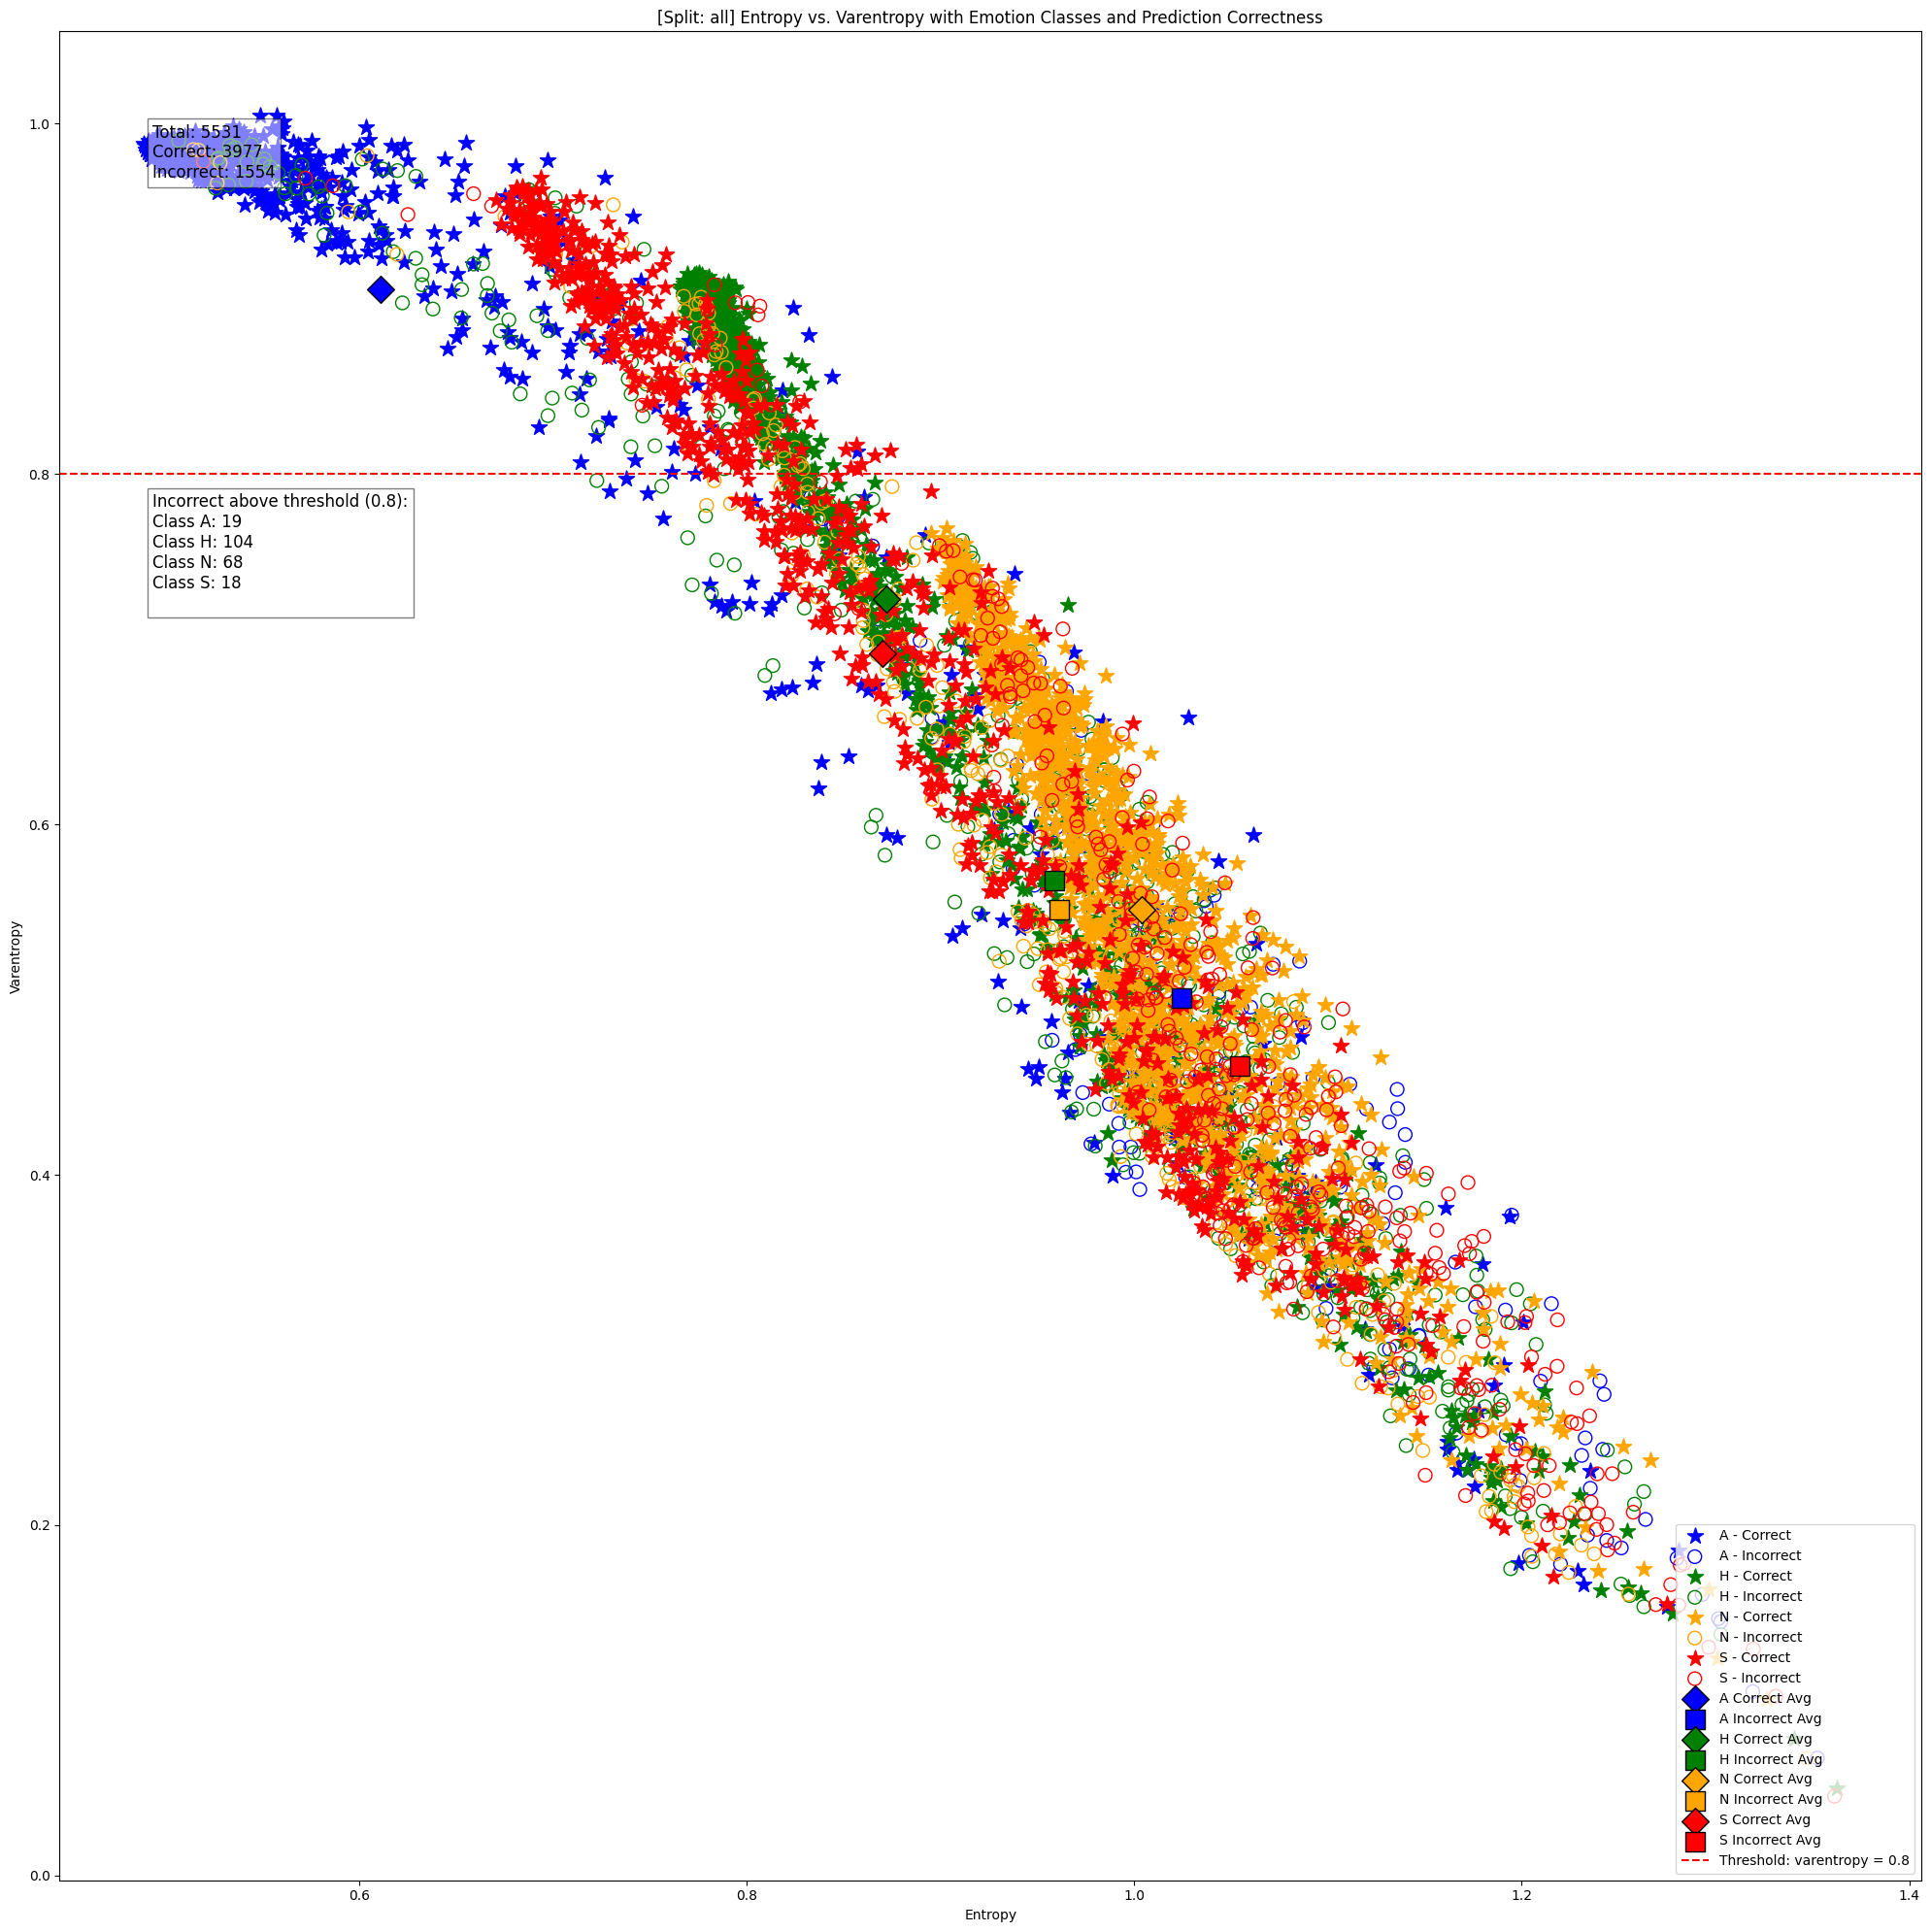

[2025-03-07 07:20:23,502][2852340423.py][line:3][INFO] Split: train
[2025-03-07 07:20:23,502][2852340423.py][line:3][INFO] Split: train
[2025-03-07 07:20:23,502][2852340423.py][line:3][INFO] Split: train
[2025-03-07 07:20:23,502][2852340423.py][line:3][INFO] Split: train
[2025-03-07 07:20:23,502][2852340423.py][line:3][INFO] Split: train
[2025-03-07 07:20:23,502][2852340423.py][line:3][INFO] Split: train
[2025-03-07 07:20:23,502][2852340423.py][line:3][INFO] Split: train
[2025-03-07 07:20:23,502][2852340423.py][line:3][INFO] Split: train
[2025-03-07 07:20:23,502][2852340423.py][line:3][INFO] Split: train
[2025-03-07 07:20:23,502][2852340423.py][line:3][INFO] Split: train
[2025-03-07 07:20:23,539][359378241.py][line:27][INFO] Total predictions: 4290
[2025-03-07 07:20:23,539][359378241.py][line:27][INFO] Total predictions: 4290
[2025-03-07 07:20:23,539][359378241.py][line:27][INFO] Total predictions: 4290
[2025-03-07 07:20:23,539][359378241.py][line:27][INFO] Total predictions: 4290
[202

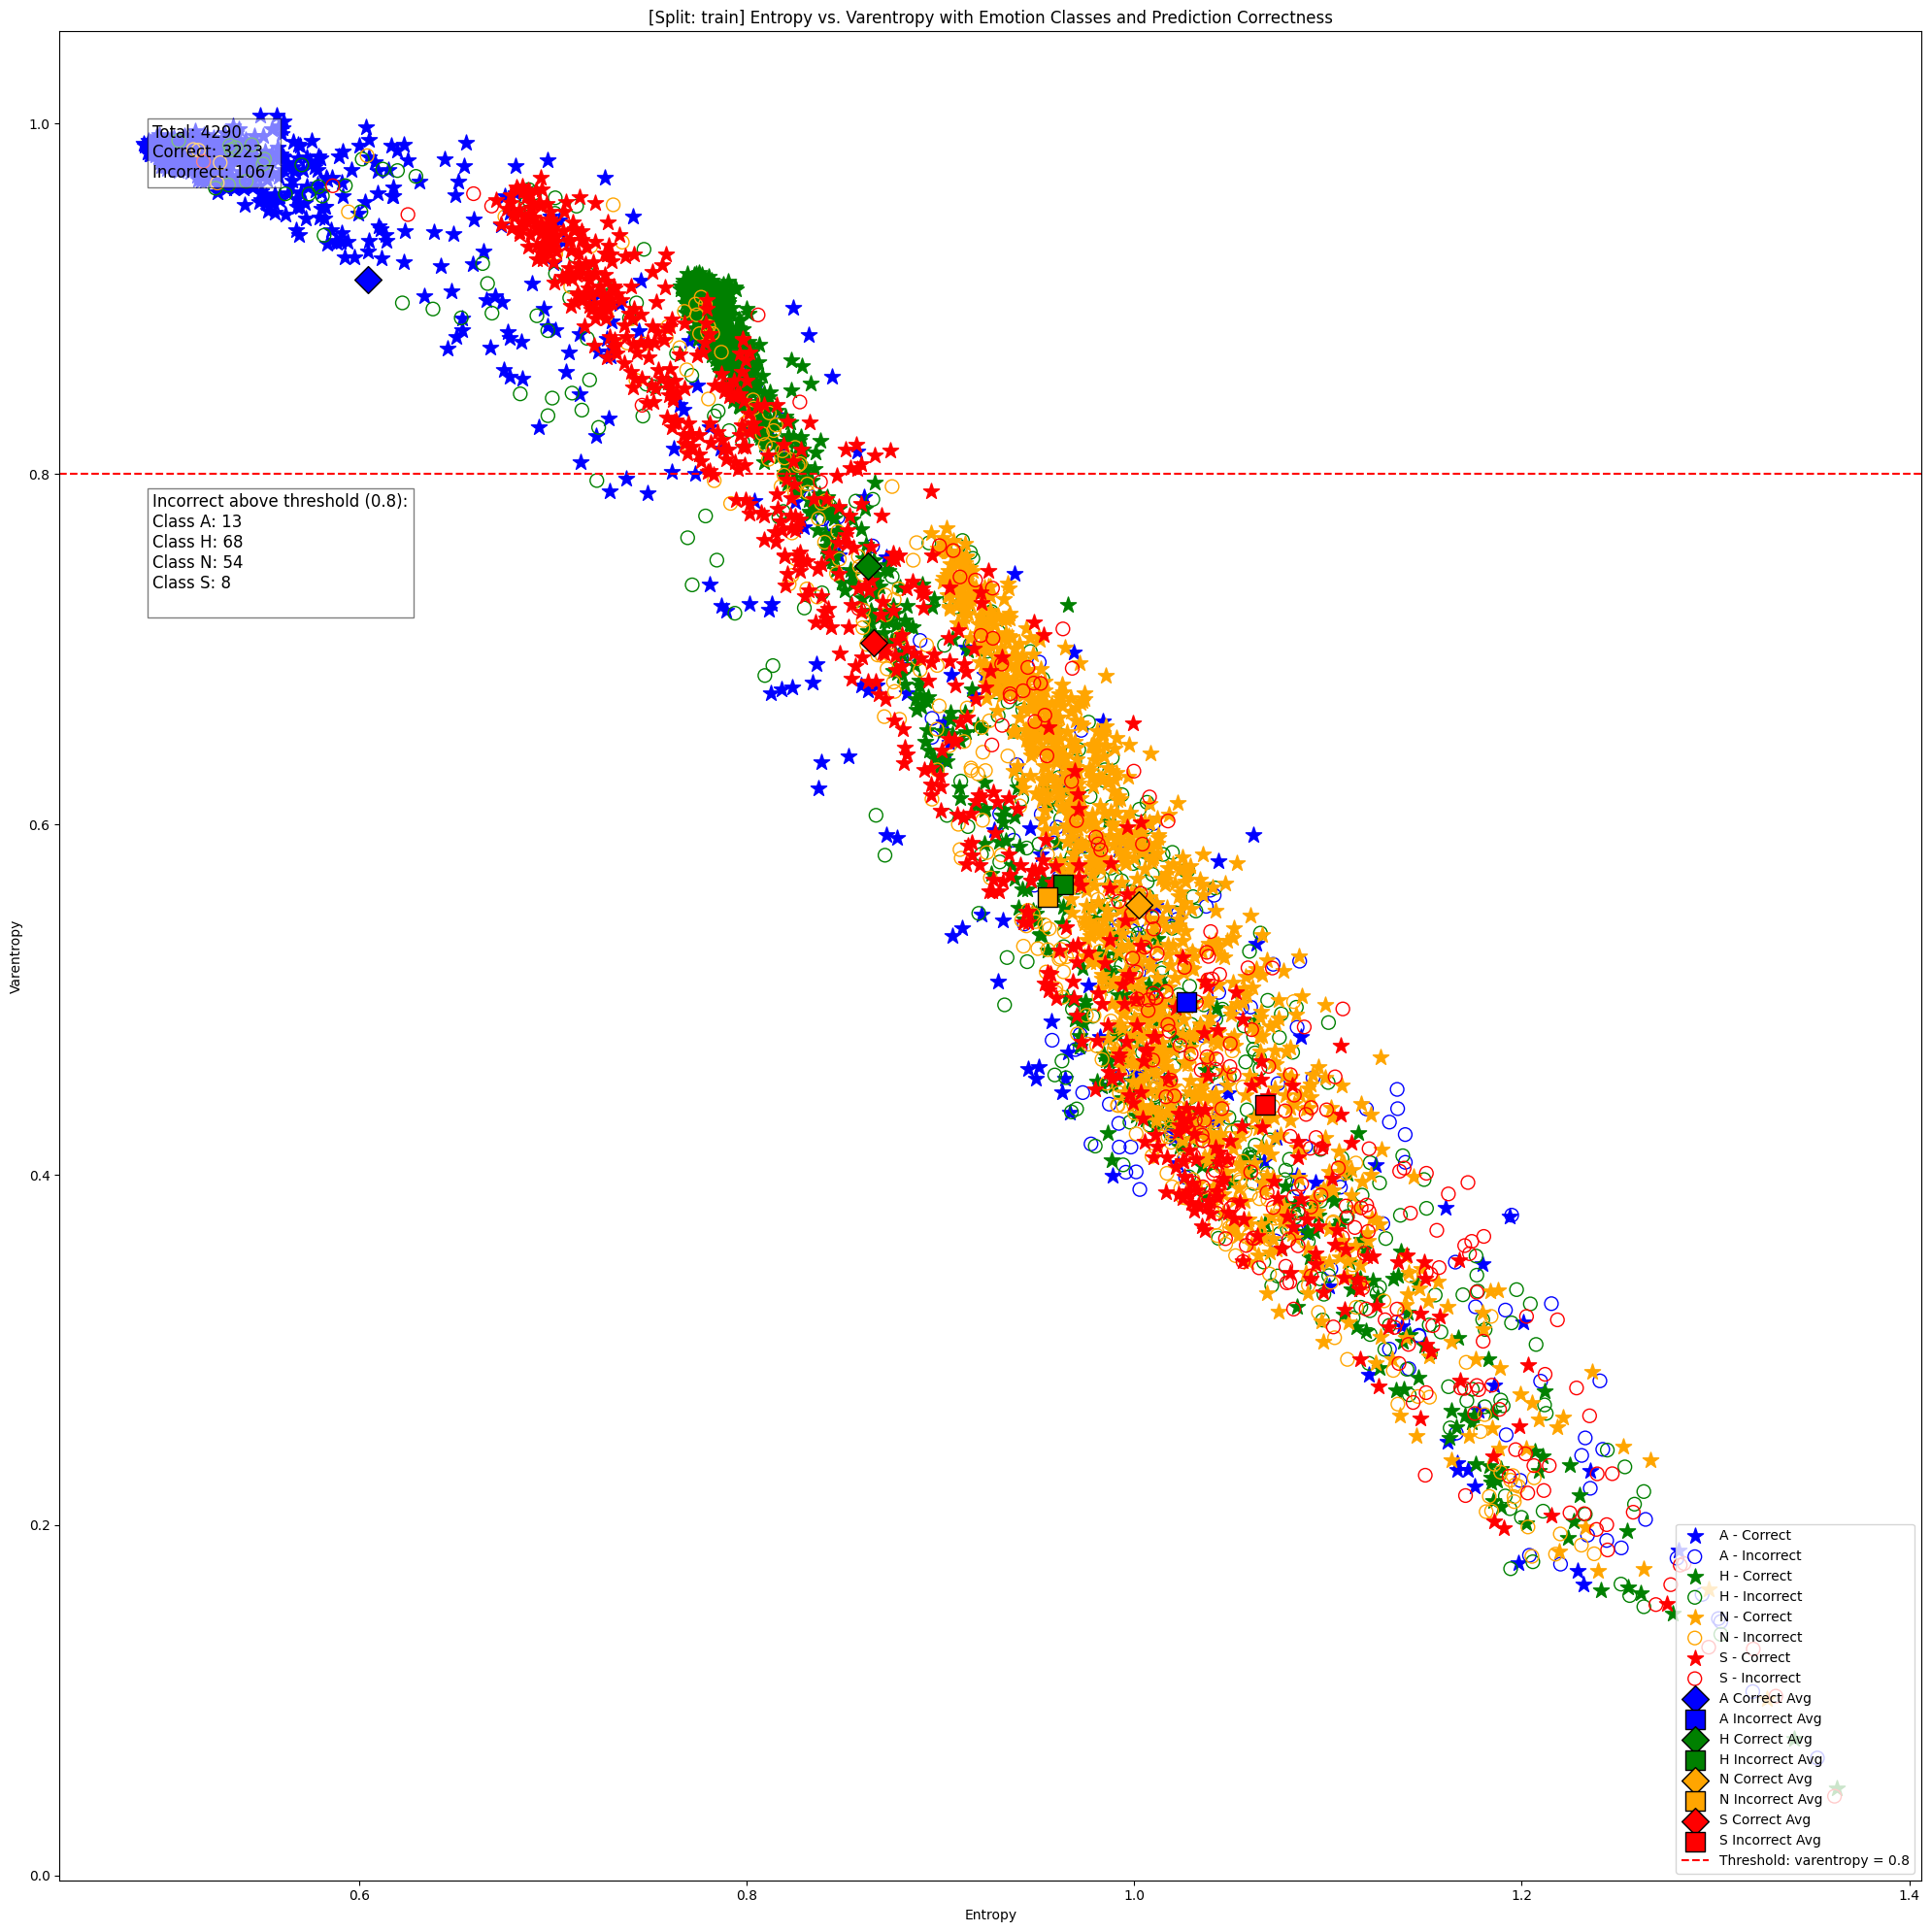

[2025-03-07 07:20:26,199][2852340423.py][line:3][INFO] Split: test
[2025-03-07 07:20:26,199][2852340423.py][line:3][INFO] Split: test
[2025-03-07 07:20:26,199][2852340423.py][line:3][INFO] Split: test
[2025-03-07 07:20:26,199][2852340423.py][line:3][INFO] Split: test
[2025-03-07 07:20:26,199][2852340423.py][line:3][INFO] Split: test
[2025-03-07 07:20:26,199][2852340423.py][line:3][INFO] Split: test
[2025-03-07 07:20:26,199][2852340423.py][line:3][INFO] Split: test
[2025-03-07 07:20:26,199][2852340423.py][line:3][INFO] Split: test
[2025-03-07 07:20:26,199][2852340423.py][line:3][INFO] Split: test
[2025-03-07 07:20:26,199][2852340423.py][line:3][INFO] Split: test
[2025-03-07 07:20:26,222][359378241.py][line:27][INFO] Total predictions: 651
[2025-03-07 07:20:26,222][359378241.py][line:27][INFO] Total predictions: 651
[2025-03-07 07:20:26,222][359378241.py][line:27][INFO] Total predictions: 651
[2025-03-07 07:20:26,222][359378241.py][line:27][INFO] Total predictions: 651
[2025-03-07 07:20:

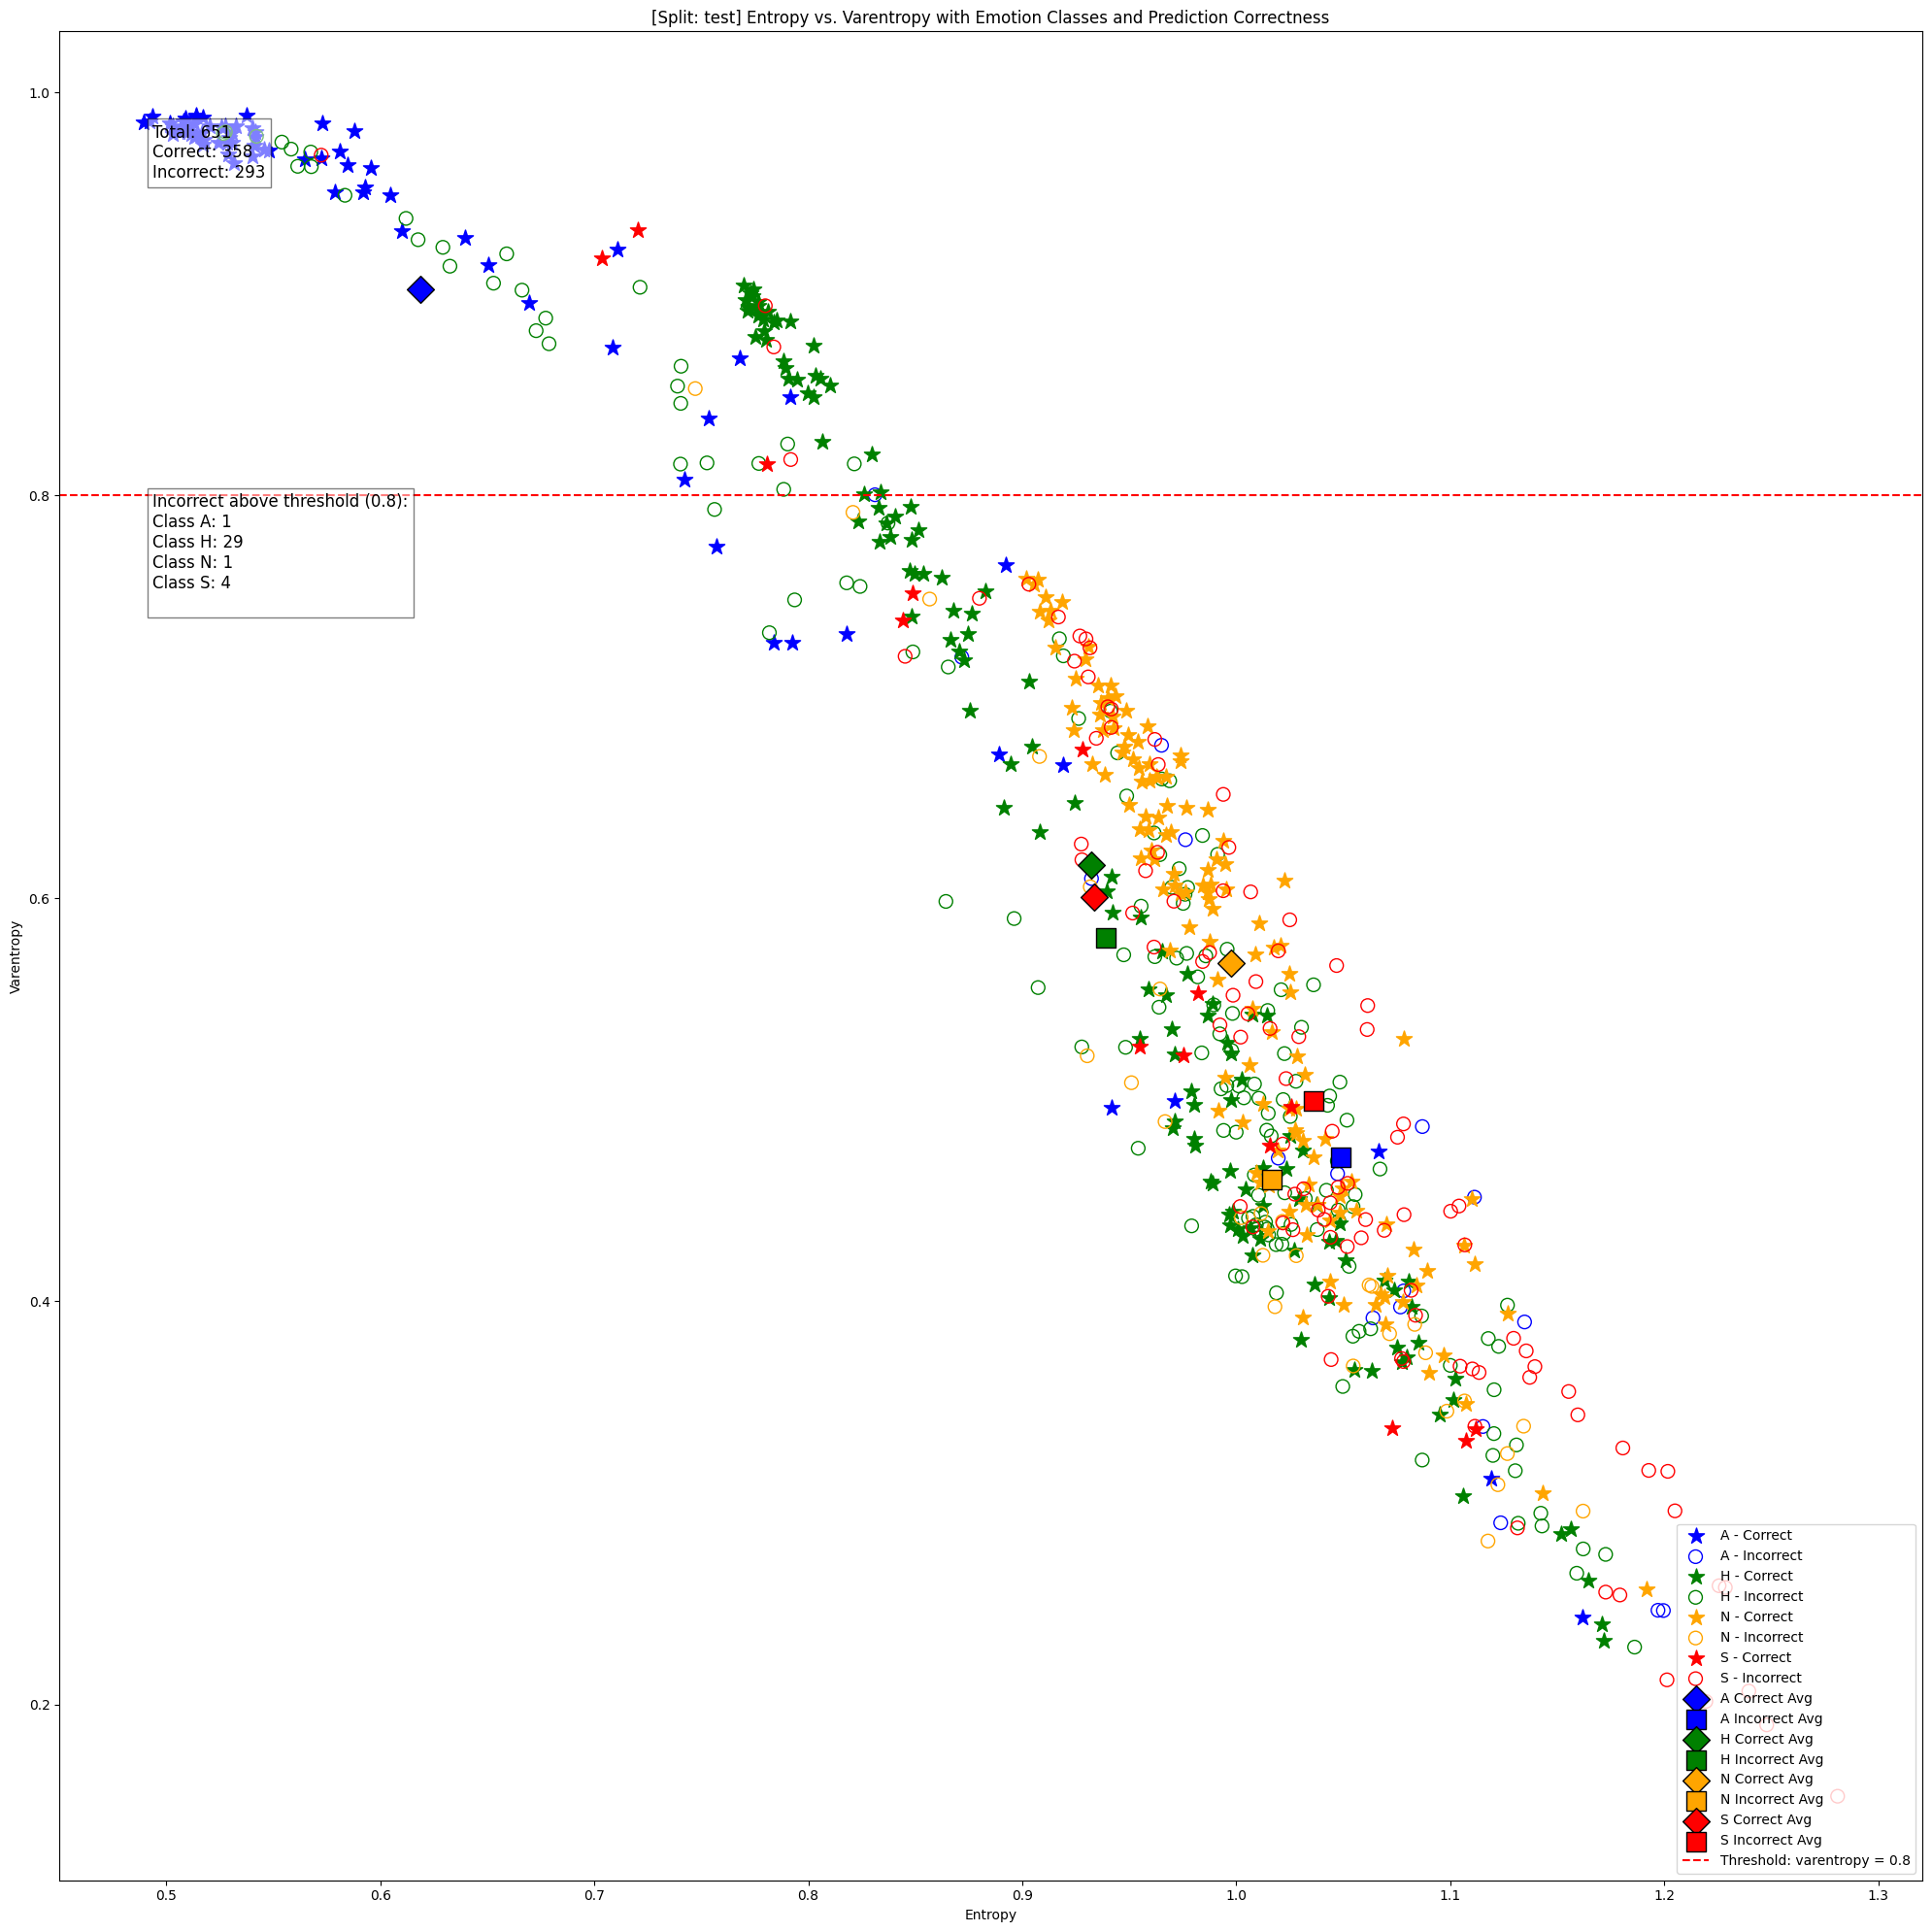

[2025-03-07 07:20:28,610][2852340423.py][line:3][INFO] Split: val
[2025-03-07 07:20:28,610][2852340423.py][line:3][INFO] Split: val
[2025-03-07 07:20:28,610][2852340423.py][line:3][INFO] Split: val
[2025-03-07 07:20:28,610][2852340423.py][line:3][INFO] Split: val
[2025-03-07 07:20:28,610][2852340423.py][line:3][INFO] Split: val
[2025-03-07 07:20:28,610][2852340423.py][line:3][INFO] Split: val
[2025-03-07 07:20:28,610][2852340423.py][line:3][INFO] Split: val
[2025-03-07 07:20:28,610][2852340423.py][line:3][INFO] Split: val
[2025-03-07 07:20:28,610][2852340423.py][line:3][INFO] Split: val
[2025-03-07 07:20:28,610][2852340423.py][line:3][INFO] Split: val
[2025-03-07 07:20:28,635][359378241.py][line:27][INFO] Total predictions: 590
[2025-03-07 07:20:28,635][359378241.py][line:27][INFO] Total predictions: 590
[2025-03-07 07:20:28,635][359378241.py][line:27][INFO] Total predictions: 590
[2025-03-07 07:20:28,635][359378241.py][line:27][INFO] Total predictions: 590
[2025-03-07 07:20:28,635][35

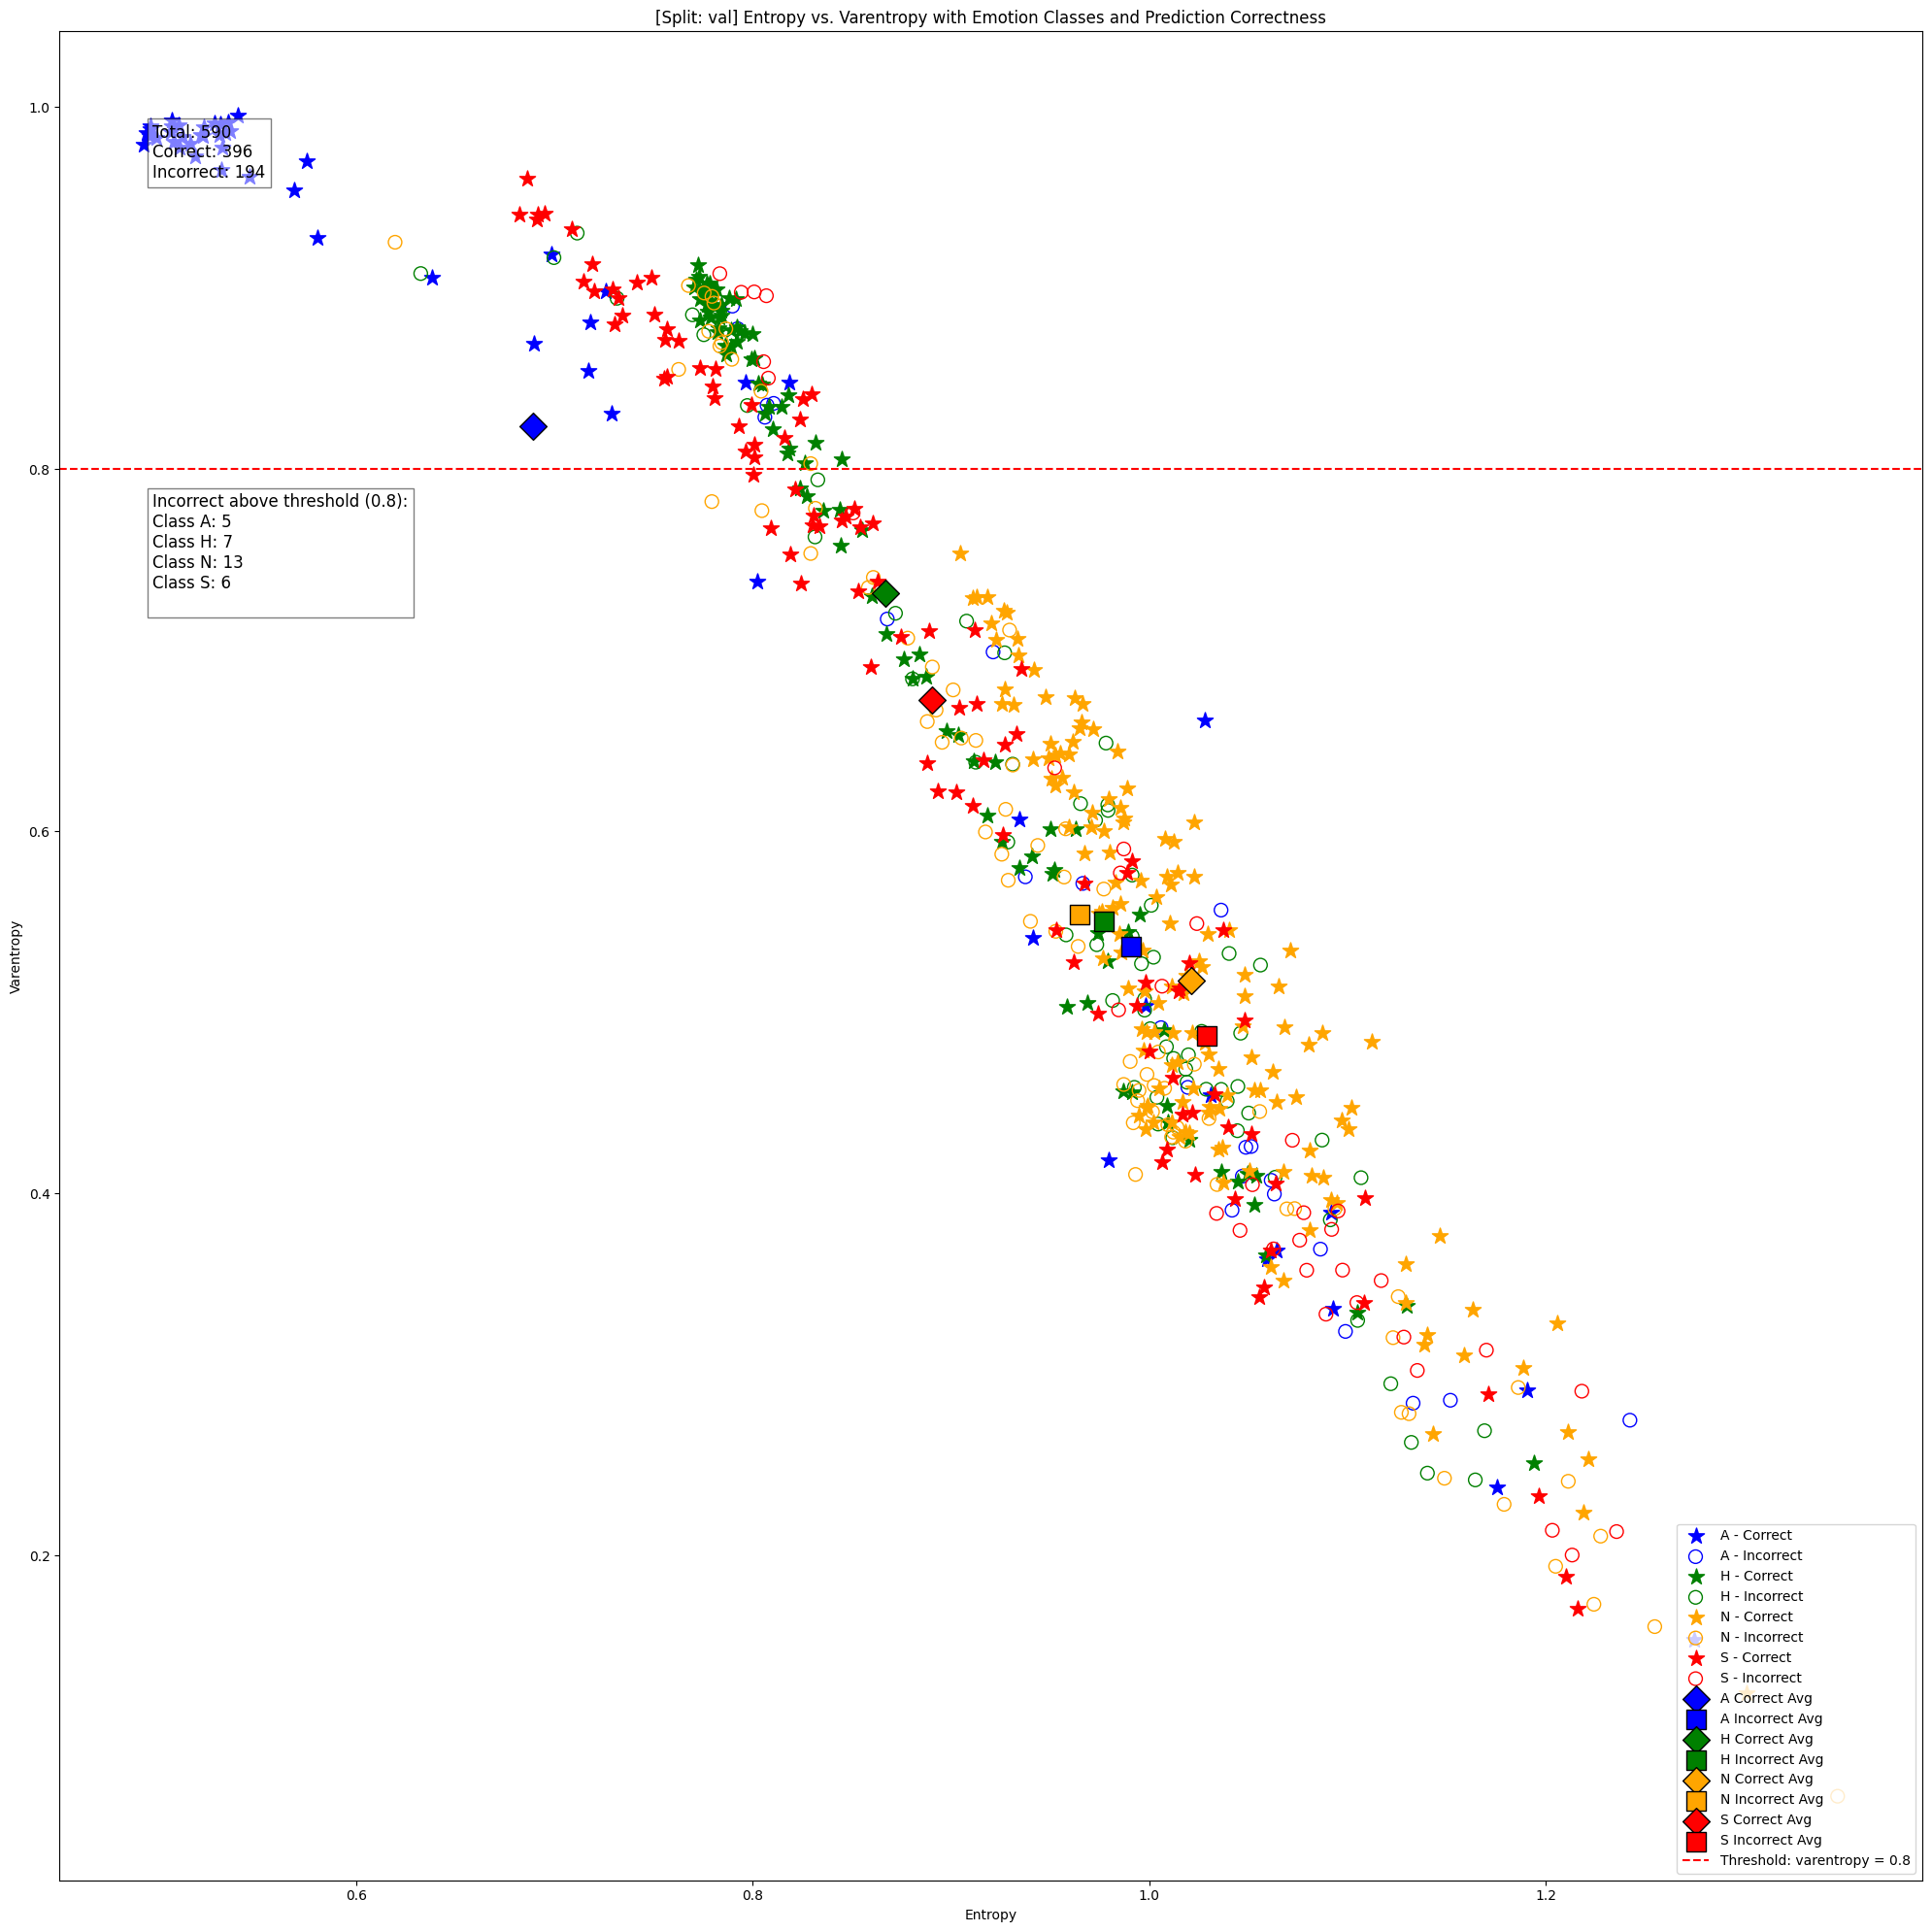

In [260]:
plot()